In [1]:
import sys
sys.path.append('../')

In [2]:
### Libraries
from pipelines.experimental_modeling_pipeline import DiabetesPreprocessing as DP
from pipelines.experimental_modeling_pipeline import AsthmaPreprocessing as AP
from pipelines.experimental_modeling_pipeline import ClusteringAnalysis as QA
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

dp = DP("C:/Users/keimp/")
ap = AP("C:/Users/keimp/")

In [64]:
from pipelines.experimental_modeling_pipeline import Experimental_modeling_pipeline as emp
emp = emp()

## Labeling

In [3]:
copd = pd.read_csv("C:/Users/keimp/NHS/Data_files/Labeling/copd_first_occurence_dates.csv")

In [4]:
copd.head()

,Participant ID,"Date J40 first reported (bronchitis, not specified as acute or chronic)",Date J41 first reported (simple and mucopurulent chronic bronchitis),Date J42 first reported (unspecified chronic bronchitis),Date J43 first reported (emphysema),Date J44 first reported (other chronic obstructive pulmonary disease),Date J47 first reported (bronchiectasis)
0,1078283,NaN,NaN,NaN,NaN,NaN,NaN
1,5170903,1991-05-01,NaN,NaN,NaN,NaN,NaN
2,5723318,NaN,NaN,NaN,NaN,NaN,NaN
3,2903197,NaN,NaN,NaN,NaN,NaN,NaN
4,5732491,NaN,NaN,NaN,NaN,NaN,NaN


Convert dates to binary

In [5]:
cols = [
       'Date J40 first reported (bronchitis, not specified as acute or chronic)',
       'Date J41 first reported (simple and mucopurulent chronic bronchitis)',
       'Date J42 first reported (unspecified chronic bronchitis)',
       'Date J43 first reported (emphysema)',
       'Date J44 first reported (other chronic obstructive pulmonary disease)',
       'Date J47 first reported (bronchiectasis)']

for i in cols:
    copd[i+"_binary"] = copd[i].apply(dp.nan_to_binary) 

In [6]:
for i in cols:
    print(i)
    print(copd[i+"_binary"].value_counts(), "\n")

Date J40 first reported (bronchitis, not specified as acute or chronic)
0    492357
1     10007
Name: Date J40 first reported (bronchitis, not specified as acute or chronic)_binary, dtype: int64 

Date J41 first reported (simple and mucopurulent chronic bronchitis)
0    502231
1       133
Name: Date J41 first reported (simple and mucopurulent chronic bronchitis)_binary, dtype: int64 

Date J42 first reported (unspecified chronic bronchitis)
0    501564
1       800
Name: Date J42 first reported (unspecified chronic bronchitis)_binary, dtype: int64 

Date J43 first reported (emphysema)
0    496357
1      6007
Name: Date J43 first reported (emphysema)_binary, dtype: int64 

Date J44 first reported (other chronic obstructive pulmonary disease)
0    474584
1     27780
Name: Date J44 first reported (other chronic obstructive pulmonary disease)_binary, dtype: int64 

Date J47 first reported (bronchiectasis)
0    495119
1      7245
Name: Date J47 first reported (bronchiectasis)_binary, dtype: 

In [7]:
def any_binary(l):
    for i in l:
        if i == 1:
            return 1
    return 0

cols_binary = [i+"_binary" for i in cols]
copd["all_copd"] = copd[cols_binary].apply(any_binary, 1)

In [8]:
copd["all_copd"].value_counts()

0    460382
1     41982
Name: all_copd, dtype: int64

#### Adding medical history

In [9]:
copd = copd.merge(pd.read_csv("C:/Users/keimp/NHS/Data_files/Grouped_files/replace/Medical_conditions.csv"), on="Participant ID")

C:\Users\keimp\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3139: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
copd["Age COPD (Chronic Obstructive Pulmonary Disease) diagnosed by doctor"].value_counts().sum()

1768

^This does not suffice

In [11]:
coding819 = pd.read_csv("C:/Users/keimp/NHS/Data_files/coding/coding819.tsv", sep="\t")
coding = coding819["coding"].tolist()
meaning = coding819["meaning"].tolist()
copd.shape

(502364, 59)

In [12]:
def delete_coding(i):
    if i in meaning:
        return 0
    return 1

for i in cols:
    copd = copd[copd[i].apply(delete_coding) ==1]

In [13]:
copd.shape

(502343, 59)

Construct earliest date

In [14]:
copd["all_copd_date"] = copd[cols].apply(dp.earliest_date, 1)

C:\Users\keimp\NHS\Code\experimental_modeling\COPD\..\pipelines\experimental_modeling_pipeline.py:744: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return pd.np.nan


In [15]:
print(copd.dtypes)

Participant ID                                                                                                         int64
Date J40 first reported (bronchitis, not specified as acute or chronic)                                               object
Date J41 first reported (simple and mucopurulent chronic bronchitis)                                                  object
Date J42 first reported (unspecified chronic bronchitis)                                                              object
Date J43 first reported (emphysema)                                                                                   object
Date J44 first reported (other chronic obstructive pulmonary disease)                                                 object
Date J47 first reported (bronchiectasis)                                                                              object
Date J40 first reported (bronchitis, not specified as acute or chronic)_binary                                         int64


Add basic demographic data

In [16]:
copd = copd.merge(pd.read_csv("C:/Users/keimp/NHS/Data_files/Grouped_files/replace/Demographics.csv"), on="Participant ID")

In [17]:
copd = copd.merge(pd.read_csv("C:/Users/keimp/NHS/Data_files/Grouped_files/replace/Dates_attending_assessment_centers_participant.csv"), on="Participant ID")

In [18]:
copd["age_copd"] = copd[["all_copd_date", "Year of birth"]].apply(ap.age_asthma, 1)

(array([ 343.,  259.,  220.,  233.,  358.,  373.,  244.,  269.,  198.,
         212.,  228.,  147.,  149.,  122.,  149.,  131.,  217.,  137.,
         131.,  145.,  111.,   92.,   96.,  146.,  127.,   95.,  108.,
         101.,  171.,  183.,  100.,  119.,  278.,  184.,  119.,  149.,
         161.,  336.,  378.,  252.,  278.,  238.,  418.,  428.,  365.,
         371.,  441.,  591., 1202.,  583.,  628.,  777.,  846.,  787.,
         958., 1000., 1106., 1097., 1134., 1218., 1223., 1225., 1236.,
        1428., 2689., 1323., 1349., 1281., 1329., 1325., 1153.,  975.,
         869.,  726.,  649.,  479.,  320.,  208.,  103.,   34.]),
 array([ 0.    ,  1.0625,  2.125 ,  3.1875,  4.25  ,  5.3125,  6.375 ,
         7.4375,  8.5   ,  9.5625, 10.625 , 11.6875, 12.75  , 13.8125,
        14.875 , 15.9375, 17.    , 18.0625, 19.125 , 20.1875, 21.25  ,
        22.3125, 23.375 , 24.4375, 25.5   , 26.5625, 27.625 , 28.6875,
        29.75  , 30.8125, 31.875 , 32.9375, 34.    , 35.0625, 36.125 ,
        37.

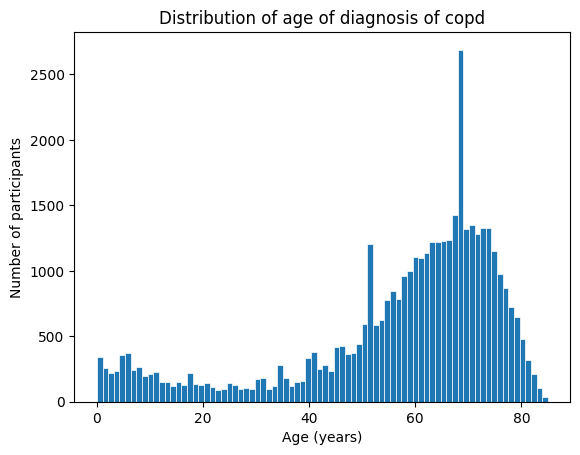

In [19]:
fig, ax = plt.subplots()
plt.title("Distribution of age of diagnosis of copd")
plt.xlabel("Age (years)")
plt.ylabel("Number of participants")
ax.hist(copd["age_copd"],bins=80 ,linewidth=0.5, edgecolor="white")

In [20]:
for i in cols:
    copd[i] = pd.to_datetime(copd[i])

(array([250., 166., 138., 159., 260., 249., 176., 199., 132., 138., 148.,
         87.,  96.,  90., 102.,  80.,  51.,  67.,  82.,  82., 165.,  59.,
         63.,  88.,  76.,  65.,  80.,  72.,  96., 110.,  72.,  68.,  74.,
        109., 123.,  80., 100., 106., 159., 162., 294., 125., 177., 182.,
        185., 174., 167., 194., 210., 197., 182., 169., 180., 184., 165.,
        215., 187., 181., 168., 179., 373., 163., 144., 149., 128., 103.,
        107.,  87.,  67.,  82.,  49.,  45.,  29.,  20.,  18.,  10.,  12.,
          5.,   1.,   2.]),
 array([ 0.  ,  1.05,  2.1 ,  3.15,  4.2 ,  5.25,  6.3 ,  7.35,  8.4 ,
         9.45, 10.5 , 11.55, 12.6 , 13.65, 14.7 , 15.75, 16.8 , 17.85,
        18.9 , 19.95, 21.  , 22.05, 23.1 , 24.15, 25.2 , 26.25, 27.3 ,
        28.35, 29.4 , 30.45, 31.5 , 32.55, 33.6 , 34.65, 35.7 , 36.75,
        37.8 , 38.85, 39.9 , 40.95, 42.  , 43.05, 44.1 , 45.15, 46.2 ,
        47.25, 48.3 , 49.35, 50.4 , 51.45, 52.5 , 53.55, 54.6 , 55.65,
        56.7 , 57.75, 58.8 ,

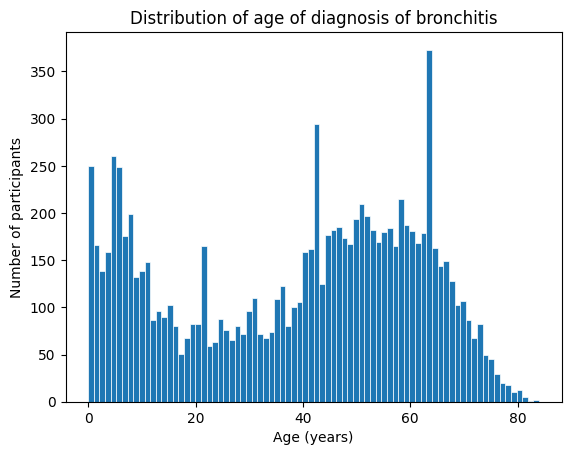

In [21]:
fig, ax = plt.subplots()
plt.title("Distribution of age of diagnosis of bronchitis")
plt.xlabel("Age (years)")
plt.ylabel("Number of participants")
ax.hist( copd["age_copd"][(copd['Date J40 first reported (bronchitis, not specified as acute or chronic)_binary'] ==1)],bins=80 ,linewidth=0.5, edgecolor="white")

(array([ 13.,   5.,  11.,  10.,  11.,  12.,   9.,   4.,   4.,   4.,  12.,
          7.,   6.,   2.,   5.,   1.,   5.,   7.,   5.,   9.,   8.,   7.,
          3.,   2.,   6.,   4.,   3.,   3.,  16.,  12.,   5.,  10.,   3.,
          8.,   8.,   3.,   8.,   9.,  31.,  34.,  52.,  28.,  47.,  56.,
         40.,  45.,  60., 105.,  99.,  82.,  74., 118., 136., 149., 135.,
        159., 151., 196., 185., 187., 414., 225., 189., 227., 232., 193.,
        209., 206., 234., 236., 232., 213., 175., 151., 125., 110.,  71.,
         67.,  40.,  28.]),
 array([ 0.  ,  1.05,  2.1 ,  3.15,  4.2 ,  5.25,  6.3 ,  7.35,  8.4 ,
         9.45, 10.5 , 11.55, 12.6 , 13.65, 14.7 , 15.75, 16.8 , 17.85,
        18.9 , 19.95, 21.  , 22.05, 23.1 , 24.15, 25.2 , 26.25, 27.3 ,
        28.35, 29.4 , 30.45, 31.5 , 32.55, 33.6 , 34.65, 35.7 , 36.75,
        37.8 , 38.85, 39.9 , 40.95, 42.  , 43.05, 44.1 , 45.15, 46.2 ,
        47.25, 48.3 , 49.35, 50.4 , 51.45, 52.5 , 53.55, 54.6 , 55.65,
        56.7 , 57.75, 58.8 ,

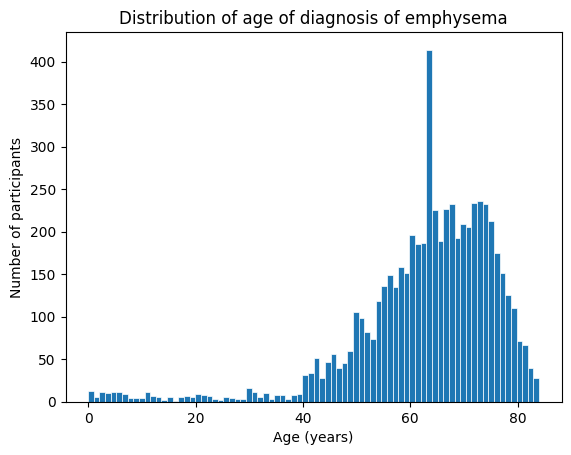

In [22]:
fig, ax = plt.subplots()
plt.title("Distribution of age of diagnosis of emphysema")
plt.xlabel("Age (years)")
plt.ylabel("Number of participants")
ax.hist( copd["age_copd"][(copd['Date J43 first reported (emphysema)_binary'] ==1)], bins=80,linewidth=0.5, edgecolor="white")

(array([ 123.,  122.,   95.,   84.,  119.,  125.,   84.,   73.,   68.,
          94.,   95.,   63.,   61.,   35.,   54.,   62.,  109.,   56.,
          59.,   69.,   44.,   44.,   30.,   65.,   56.,   34.,   30.,
          30.,   88.,   82.,   29.,   52.,   95.,   76.,   39.,   49.,
          56.,  188.,  245.,  108.,  136.,  109.,  242.,  250.,  182.,
         191.,  268.,  409.,  779.,  367.,  424.,  550.,  627.,  570.,
         693.,  740.,  859.,  847.,  848.,  895.,  918.,  914.,  945.,
        1075., 2074.,  970., 1005.,  967.,  947.,  979.,  843.,  701.,
         618.,  516.,  449.,  336.,  207.,  146.,   64.,   26.]),
 array([ 0.    ,  1.0625,  2.125 ,  3.1875,  4.25  ,  5.3125,  6.375 ,
         7.4375,  8.5   ,  9.5625, 10.625 , 11.6875, 12.75  , 13.8125,
        14.875 , 15.9375, 17.    , 18.0625, 19.125 , 20.1875, 21.25  ,
        22.3125, 23.375 , 24.4375, 25.5   , 26.5625, 27.625 , 28.6875,
        29.75  , 30.8125, 31.875 , 32.9375, 34.    , 35.0625, 36.125 ,
        37.

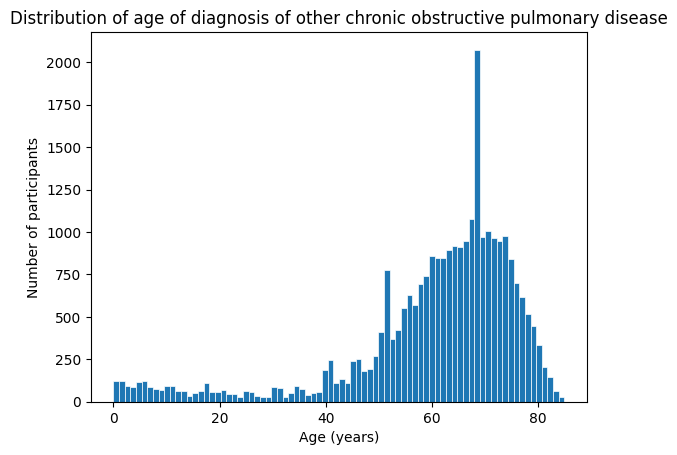

In [23]:
fig, ax = plt.subplots()
plt.title("Distribution of age of diagnosis of other chronic obstructive pulmonary disease")
plt.xlabel("Age (years)")
plt.ylabel("Number of participants")
ax.hist( copd["age_copd"][(copd['Date J44 first reported (other chronic obstructive pulmonary disease)_binary'] ==1)], bins=80,linewidth=0.5, edgecolor="white")

(array([ 48.,  44.,  37.,  32.,  45.,  56.,  35.,  33.,  27.,  24.,  29.,
         18.,  21.,  13.,  30.,  18.,  23.,  13.,  20.,  19.,  29.,  12.,
         16.,  11.,  12.,   9.,  14.,  13.,  13.,  29.,  11.,  13.,  10.,
         25.,  25.,  14.,  16.,  17.,  38.,  37.,  58.,  30.,  58.,  48.,
         48.,  44.,  59.,  76.,  91.,  79.,  86.,  92., 122., 144., 127.,
        141., 172., 194., 180., 190., 424., 234., 219., 253., 246., 278.,
        270., 280., 248., 276., 283., 241., 215., 211., 173., 146., 118.,
         72.,  41.,  29.]),
 array([ 0.  ,  1.05,  2.1 ,  3.15,  4.2 ,  5.25,  6.3 ,  7.35,  8.4 ,
         9.45, 10.5 , 11.55, 12.6 , 13.65, 14.7 , 15.75, 16.8 , 17.85,
        18.9 , 19.95, 21.  , 22.05, 23.1 , 24.15, 25.2 , 26.25, 27.3 ,
        28.35, 29.4 , 30.45, 31.5 , 32.55, 33.6 , 34.65, 35.7 , 36.75,
        37.8 , 38.85, 39.9 , 40.95, 42.  , 43.05, 44.1 , 45.15, 46.2 ,
        47.25, 48.3 , 49.35, 50.4 , 51.45, 52.5 , 53.55, 54.6 , 55.65,
        56.7 , 57.75, 58.8 ,

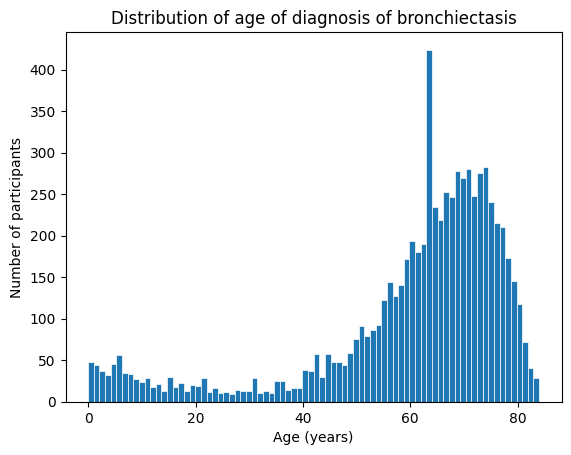

In [24]:
fig, ax = plt.subplots()
plt.title("Distribution of age of diagnosis of bronchiectasis")
plt.xlabel("Age (years)")
plt.ylabel("Number of participants")
ax.hist( copd["age_copd"][(copd['Date J47 first reported (bronchiectasis)_binary'] ==1)], bins=80,linewidth=0.5, edgecolor="white")

## Smoking

In [25]:
copd = copd.merge(pd.read_csv("C:/Users/keimp/NHS/Data_files/Grouped_files/replace/Smoking.csv"), on="Participant ID")

C:\Users\keimp\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3139: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<BarContainer object of 4 artists>

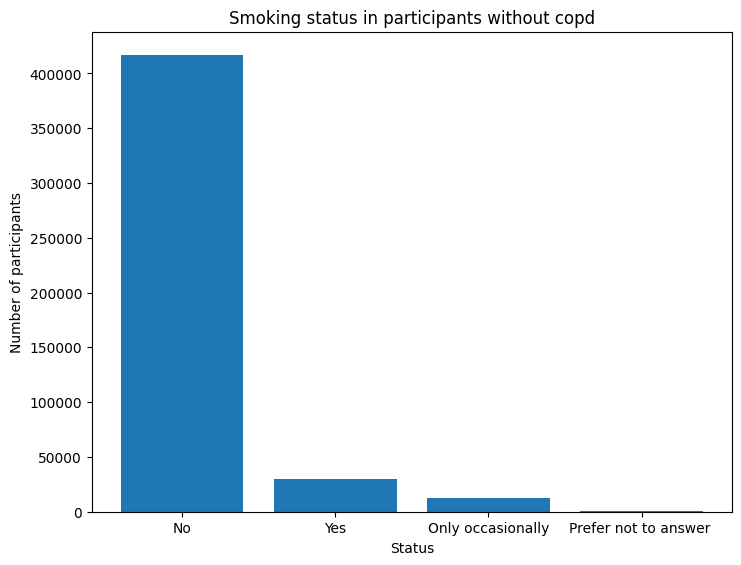

In [29]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking status in participants without copd")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["No", "Yes", "Only occasionally", "Prefer not to answer "]
data = [copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["No"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Yes, on most or all days"],
       copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Only occasionally"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)

<BarContainer object of 4 artists>

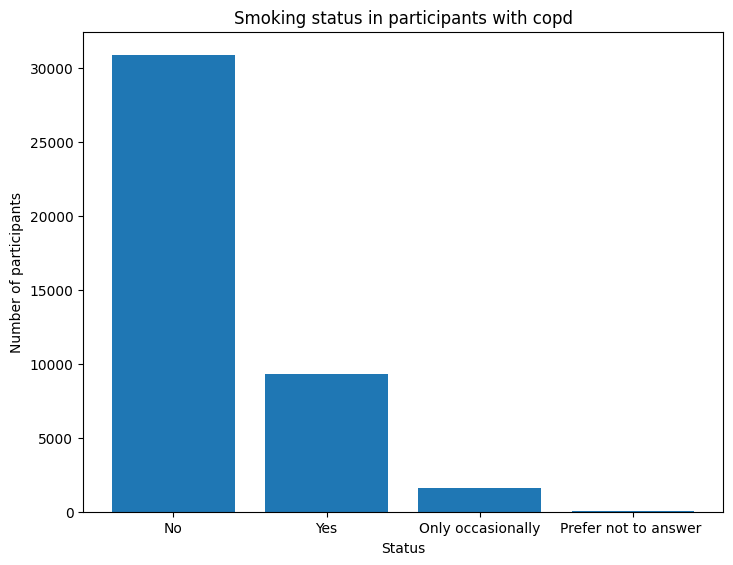

In [30]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking status in participants with copd")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["No", "Yes", "Only occasionally", "Prefer not to answer "]
data = [copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["No"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Yes, on most or all days"],
       copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Only occasionally"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)

Smoking status per subtype

<BarContainer object of 4 artists>

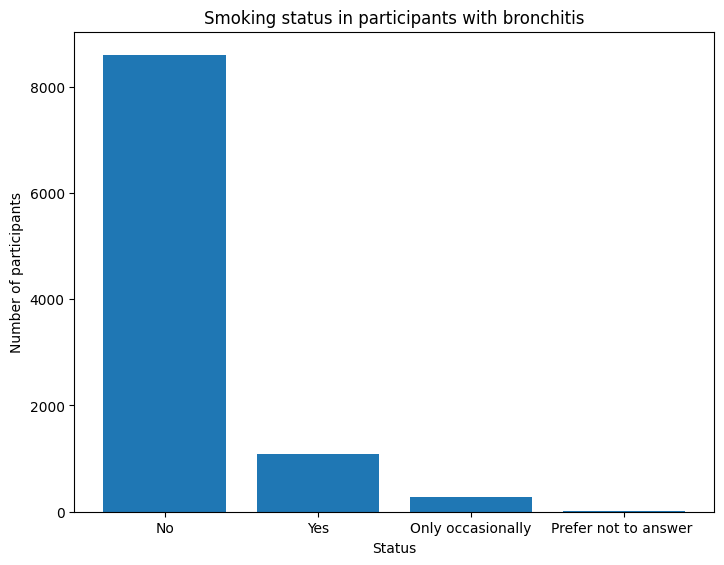

In [31]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking status in participants with bronchitis")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["No", "Yes", "Only occasionally", "Prefer not to answer "]
data = [copd["Current tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["No"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Yes, on most or all days"],
       copd["Current tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Only occasionally"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)

<BarContainer object of 4 artists>

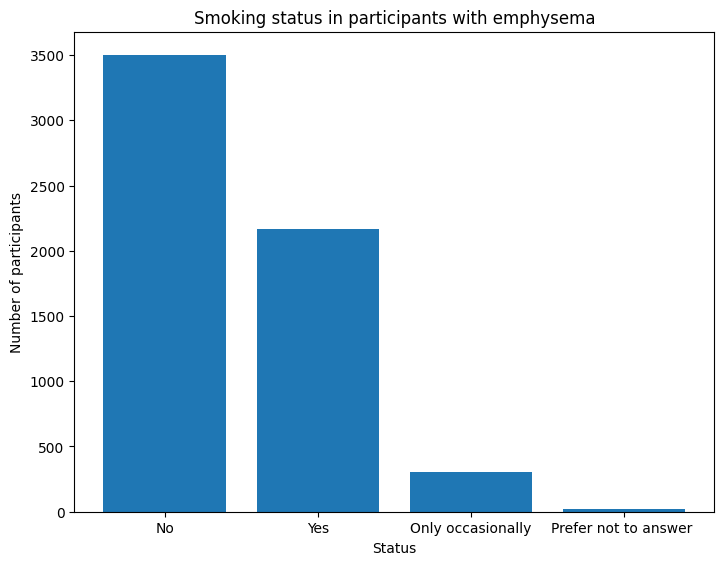

In [33]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking status in participants with emphysema")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["No", "Yes", "Only occasionally", "Prefer not to answer "]
data = [copd["Current tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["No"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Yes, on most or all days"],
       copd["Current tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Only occasionally"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)

<BarContainer object of 4 artists>

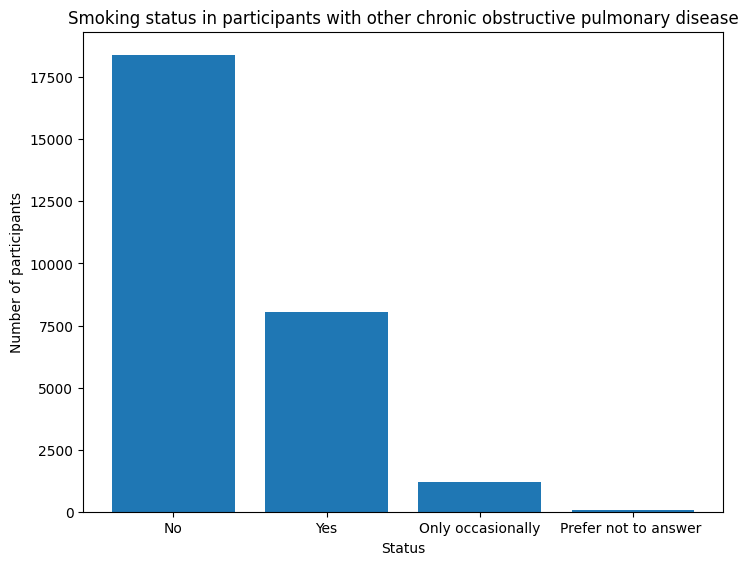

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking status in participants with other chronic obstructive pulmonary disease")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["No", "Yes", "Only occasionally", "Prefer not to answer "]
data = [copd["Current tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["No"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Yes, on most or all days"],
       copd["Current tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Only occasionally"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)

<BarContainer object of 4 artists>

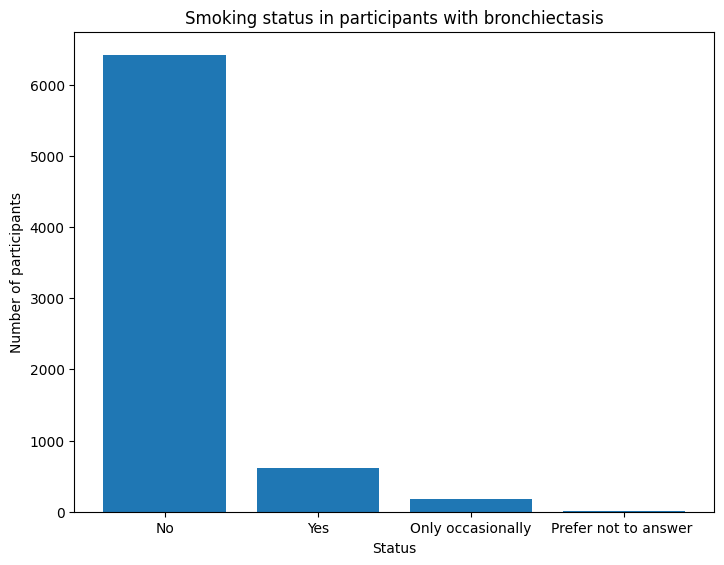

In [35]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking status in participants with bronchiectasis")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["No", "Yes", "Only occasionally", "Prefer not to answer "]
data = [copd["Current tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["No"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Yes, on most or all days"],
       copd["Current tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Only occasionally"], 
        copd["Current tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)

#### smoking history

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

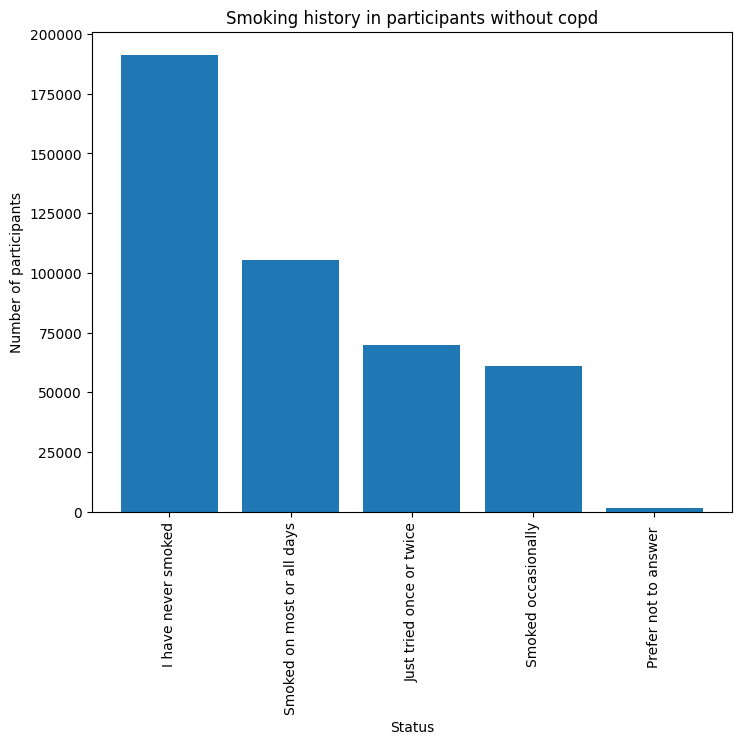

In [43]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants without copd")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 0].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

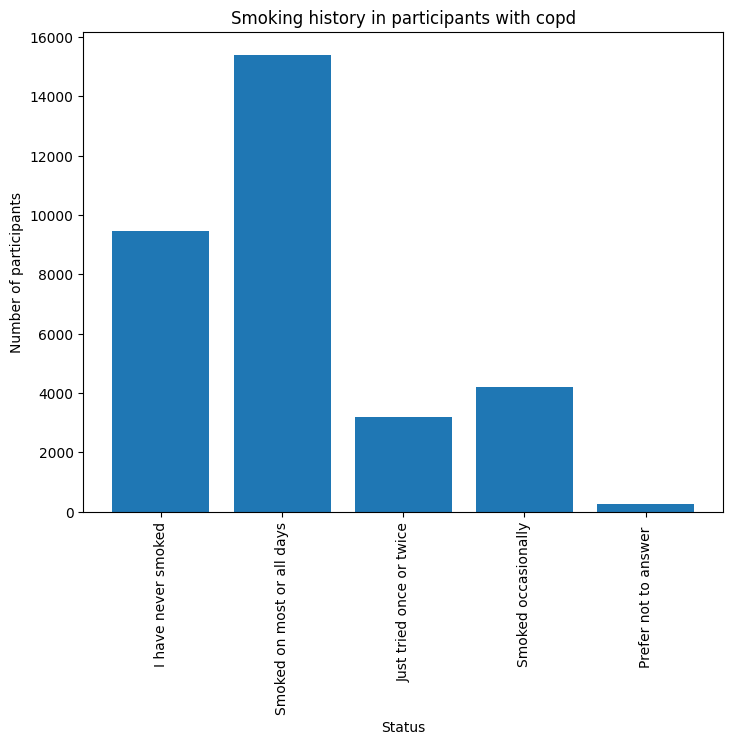

In [46]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with copd")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["all_copd"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

per subtype

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

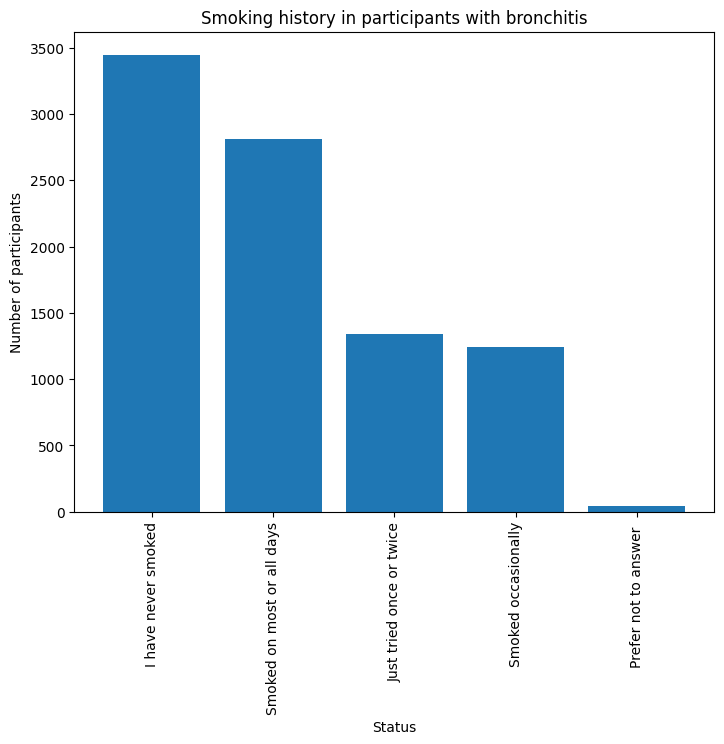

In [47]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with bronchitis")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

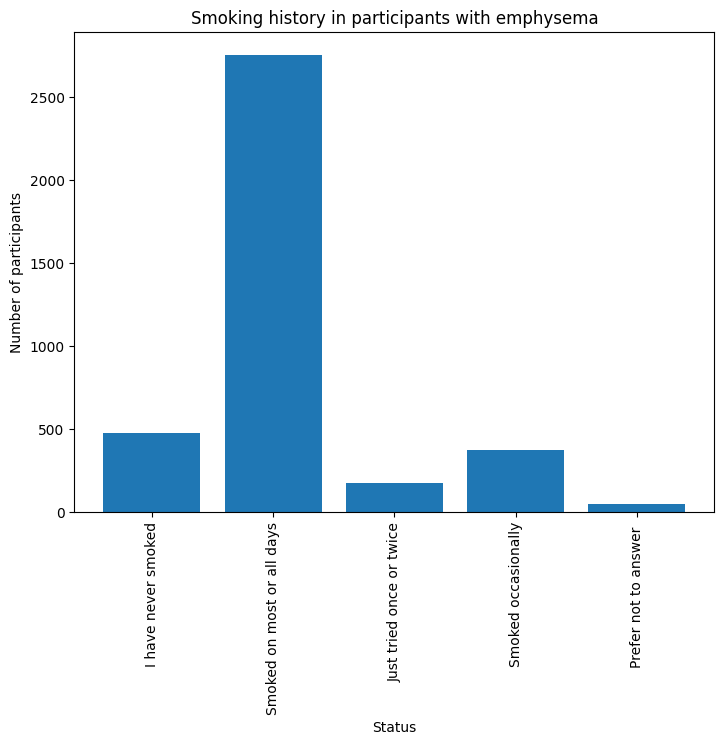

In [48]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with emphysema")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J43 first reported (emphysema)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

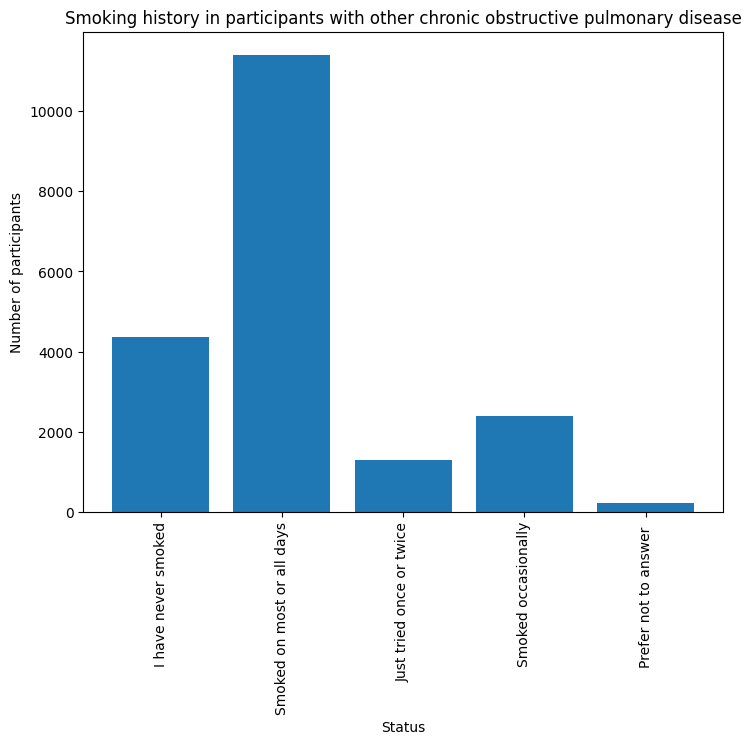

In [49]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with other chronic obstructive pulmonary disease")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

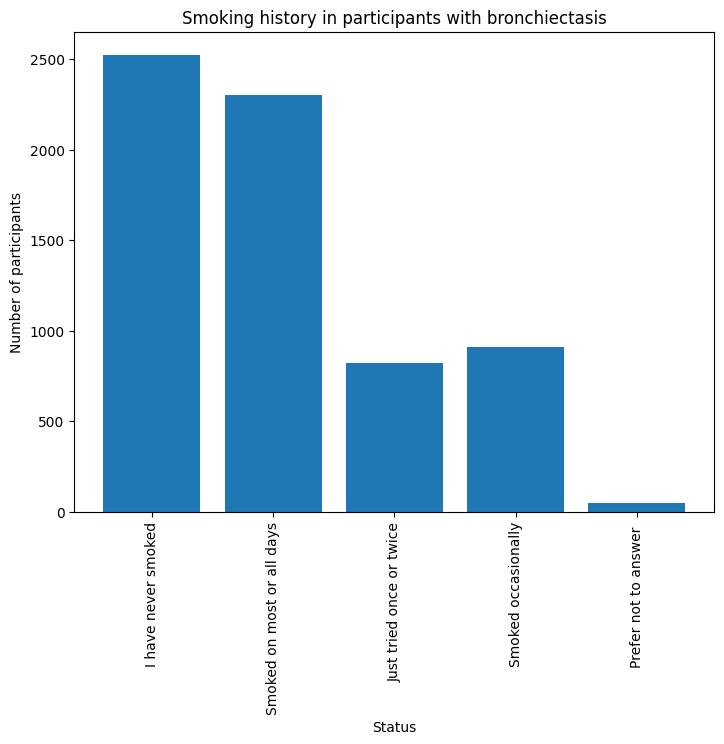

In [50]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with bronchiectasis")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[copd["Date J47 first reported (bronchiectasis)_binary"] == 1].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

Bronchitis and age

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

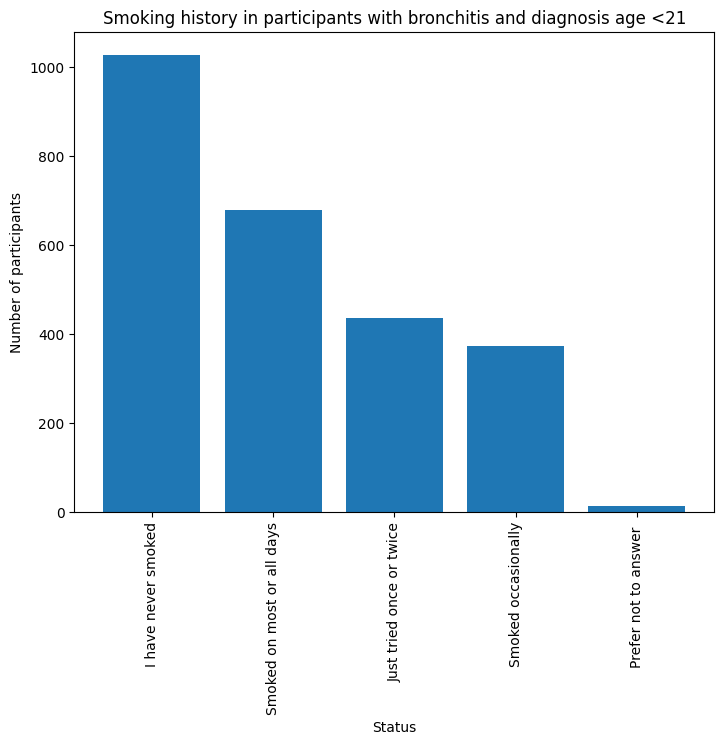

In [52]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with bronchitis and diagnosis age <21")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] <21)].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] <21)].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] <21)].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] <21)].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] <21)].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

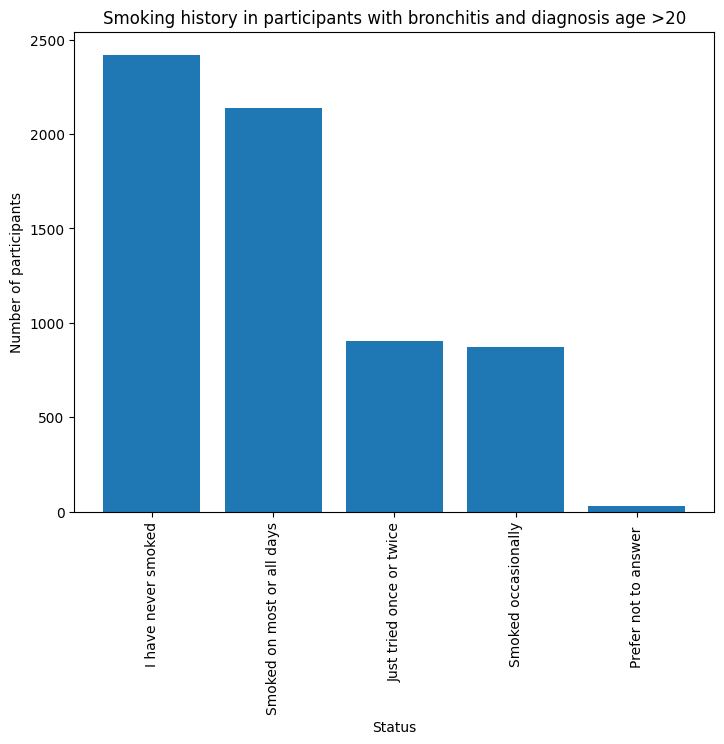

In [53]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with bronchitis and diagnosis age >20")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >20)].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >20)].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >20)].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >20)].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >20)].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4],
 [Text(0, 0, 'I have never smoked'),
  Text(1, 0, 'Smoked on most or all days'),
  Text(2, 0, 'Just tried once or twice'),
  Text(3, 0, 'Smoked occasionally'),
  Text(4, 0, 'Prefer not to answer ')])

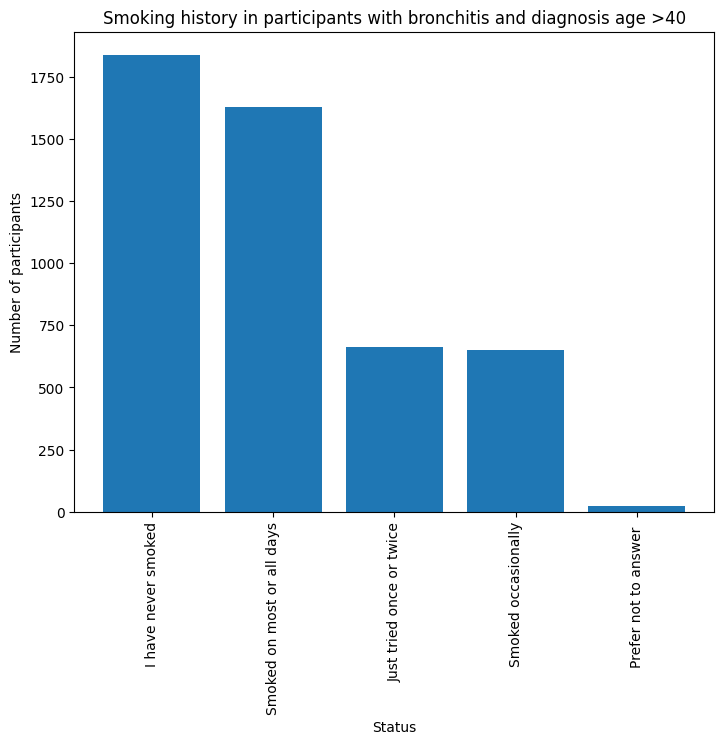

In [56]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Smoking history in participants with bronchitis and diagnosis age >40")
ax.set_ylabel("Number of participants")
ax.set_xlabel("Status")
labels = ["I have never smoked", "Smoked on most or all days", "Just tried once or twice","Smoked occasionally" ,"Prefer not to answer "]
data = [copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >40)].value_counts()["I have never smoked"], 
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >40)].value_counts()["Smoked on most or all days"],
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >40)].value_counts()["Just tried once or twice"],
       copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >40)].value_counts()["Smoked occasionally"], 
        copd["Past tobacco smoking | Instance 0"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) &(copd["age_copd"] >40)].value_counts()["Prefer not to answer"]]
ax.bar(labels,data)
plt.xticks(rotation=90)

### Modeling on smoking only

In [68]:
one_hot = pd.get_dummies(copd['Current tobacco smoking | Instance 0'])
copd = pd.concat([copd, one_hot], axis=1)

one_hot = pd.get_dummies(copd['Past tobacco smoking | Instance 0'])
copd = pd.concat([copd, one_hot], axis=1)

In [70]:
datacolumns_selected = ['No',
 'Only occasionally',
 'Yes, on most or all days',
 'I have never smoked',
 'Just tried once or twice',
 'Smoked occasionally',
 'Smoked on most or all days'
                       ]
datacolumns_selected_lab = ['No',
 'Only occasionally',
 'Yes, on most or all days',
 'I have never smoked',
 'Just tried once or twice',
 'Smoked occasionally',
 'Smoked on most or all days',
                            'all_copd'
                       ]

In [71]:
cohort = pd.concat([copd[copd["all_copd"] == 1], copd[copd["all_copd"] == 0 ].sample(copd[copd["all_copd"] == 1].shape[0])])
cohort = cohort[datacolumns_selected_lab]

Number of missing values: 
 No                            0
Only occasionally             0
Yes, on most or all days      0
I have never smoked           0
Just tried once or twice      0
Smoked occasionally           0
Smoked on most or all days    0
all_copd                      0
dtype: int64
Dataframe dimensions:  (83922, 8)


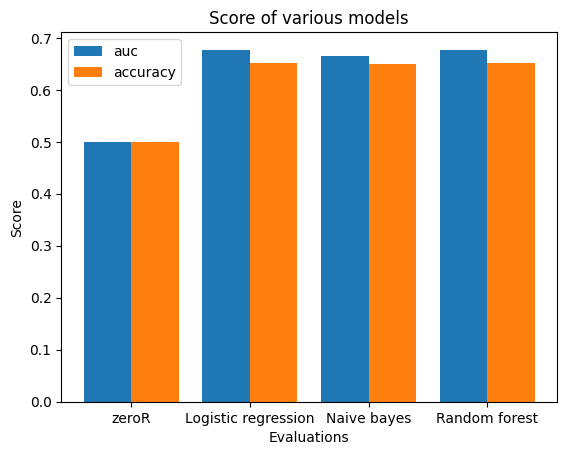

F1:  0.6377431094859777 0.6355010707773329 0.6331931955011391
auc:  [0.5, 0.6768890013358009, 0.6652339749254997, 0.677121750203517]
accuracy:  [0.5, 0.6516169981027934, 0.6505445651886856, 0.6516289241523411]


In [72]:
emp.pipeline(cohort, "all_copd", datacolumns_selected,0.25, splits=5)

To be diagnosed only

In [78]:
cohort = pd.concat([copd[(copd["all_copd"] == 1) & (copd["age_copd"] > copd["Age at recruitment"])], copd[copd["all_copd"] == 0 ].sample(copd[copd["all_copd"] == 1].shape[0])])
cohort = cohort[datacolumns_selected_lab]

Number of missing values: 
 No                            0
Only occasionally             0
Yes, on most or all days      0
I have never smoked           0
Just tried once or twice      0
Smoked occasionally           0
Smoked on most or all days    0
all_copd                      0
dtype: int64
Dataframe dimensions:  (65929, 8)


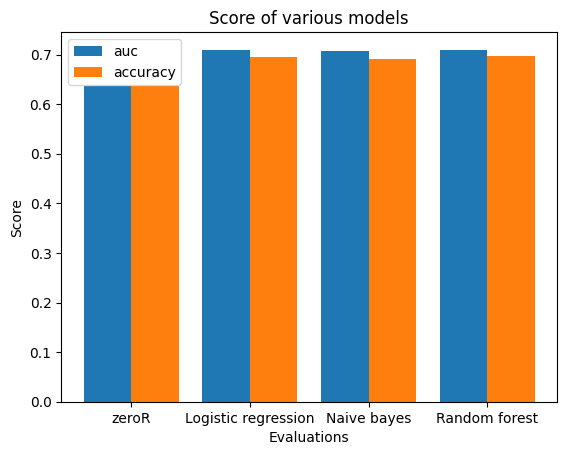

F1:  0.41616342310426435 0.4258963517089465 0.417387499193496
auc:  [0.6364574011436546, 0.709805160652592, 0.706683564002804, 0.7098119537898114]
accuracy:  [0.6364574011436546, 0.6956726365588904, 0.6920930445242455, 0.6964158766658263]


In [79]:
emp.pipeline(cohort, "all_copd", datacolumns_selected,0.25, splits=5)

Number of missing values: 
 No                            0
Only occasionally             0
Yes, on most or all days      0
I have never smoked           0
Just tried once or twice      0
Smoked occasionally           0
Smoked on most or all days    0
all_copd                      0
dtype: int64
Dataframe dimensions:  (65929, 8)


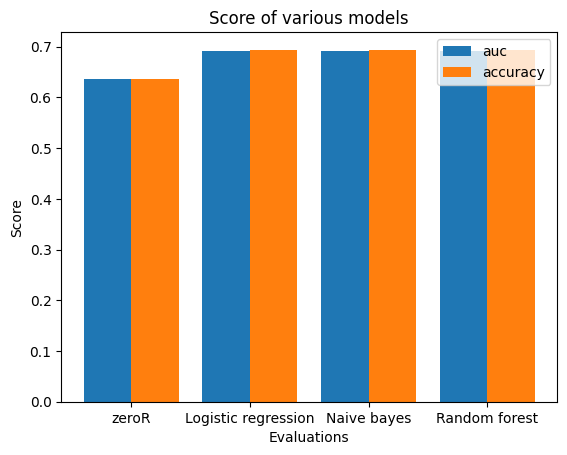

F1:  0.3914110270673908 0.3914110270673908 0.3914110270673908
auc:  [0.6364574011436546, 0.6921679232146776, 0.6921679232146776, 0.6921679232146776]
accuracy:  [0.6364574011436546, 0.6939283496745983, 0.6939283496745983, 0.6939283496745983]


In [80]:
emp.pipeline(cohort, "all_copd", ["Yes, on most or all days", "Smoked on most or all days"],0.25, splits=5)

## Atopy

In [88]:
copd =copd.merge(ap.pre_medical_conditions(), on="Participant ID")

C:\Users\keimp\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py:3318: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  if await self.run_code(code, result, async_=asy):
C:\Users\keimp\NHS\Code\experimental_modeling\COPD\..\pipelines\experimental_modeling_pipeline.py:1101: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return pd.np.nan
C:\Users\keimp\NHS\Code\experimental_modeling\COPD\..\pipelines\experimental_modeling_pipeline.py:1108: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  return pd.np.nan
C:\Users\keimp\NHS\Code\experimental_modeling\COPD\..\pipelines\experimental_modeling_pipeline.py:1115: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

all copd

In [90]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["all_copd"] == 1) ].value_counts()

0    34497
1     7464
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

Subtypes

In [92]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) ].value_counts()

0    7583
1    2405
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [94]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Date J43 first reported (emphysema)_binary"] == 1) ].value_counts()

0    5345
1     661
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [95]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1) ].value_counts()

0    23788
1     3988
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [96]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Date J47 first reported (bronchiectasis)_binary"] == 1) ].value_counts()

0    5831
1    1414
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

Smoking

In [97]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 1) & (copd["all_copd"] == 1) ].value_counts()

0    13059
1     2342
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [98]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 0) & (copd["all_copd"] == 1) ].value_counts()

0    21438
1     5122
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [99]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 1) & (copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) ].value_counts()

0    2223
1     592
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [100]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 0) & (copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) ].value_counts()

0    5360
1    1813
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [101]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 1) & (copd["Date J43 first reported (emphysema)_binary"] == 1) ].value_counts()

0    2494
1     262
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [102]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 0) & (copd["Date J43 first reported (emphysema)_binary"] == 1) ].value_counts()

0    2851
1     399
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [103]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 1) & (copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1) ].value_counts()

0    9937
1    1477
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [104]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Smoked on most or all days"] == 0) & (copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1) ].value_counts()

0    13851
1     2511
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

age

In [108]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) & (copd["age_copd"] < 30 )].value_counts()

0    2473
1     947
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

In [109]:
copd["Hayfever_allergic_rhinitis_eczema_doctor"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1) & (copd["age_copd"] > 30 )].value_counts()

0    5044
1    1428
Name: Hayfever_allergic_rhinitis_eczema_doctor, dtype: int64

### Bronchitis clustering

In [111]:
datacolumns_selected = ["Hayfever_allergic_rhinitis_eczema_doctor",
                        "age_copd",
                        "Smoked on most or all days"
                       ]


c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\

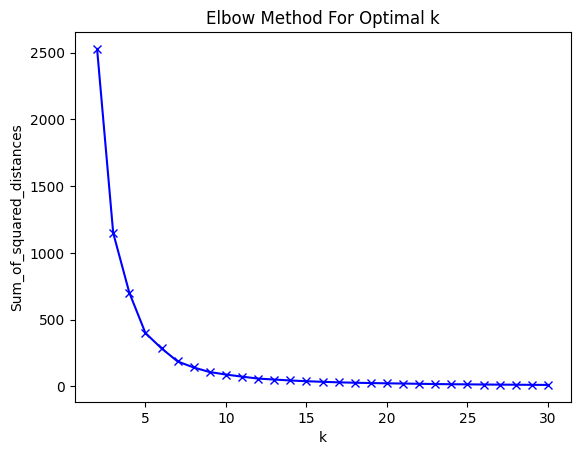

In [114]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=30, wd="C:/Users/keimp/")
qa.elbow_method()

In [115]:
#visualization function
def boxplot_timseries(data, title, abline=False):
    fig = plt.figure()
     
    # Creating axes instance
    ax = fig.add_axes([0, 0, 1, 1])
    ax.set_title(title)
    
    # Creating plot
    bp = ax.boxplot(data)
    #plt.xticks([1, 2], ['df1', 'df2'])
    if abline != False:
        plt.axvline(x = abline, color = 'b')
    
    plt.show()

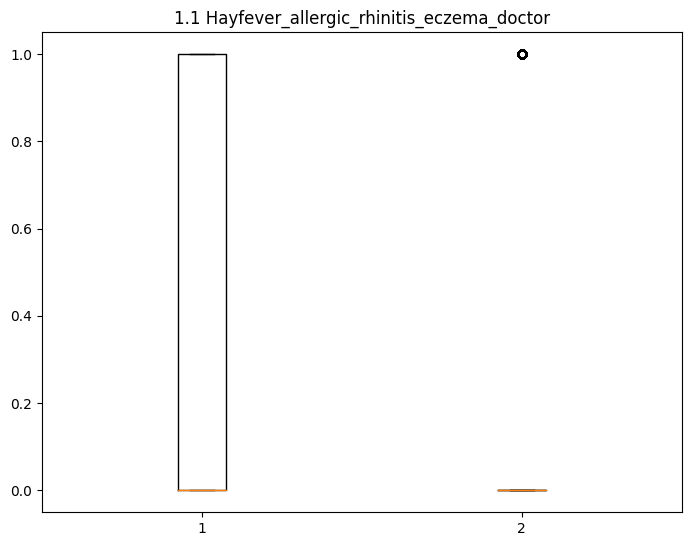

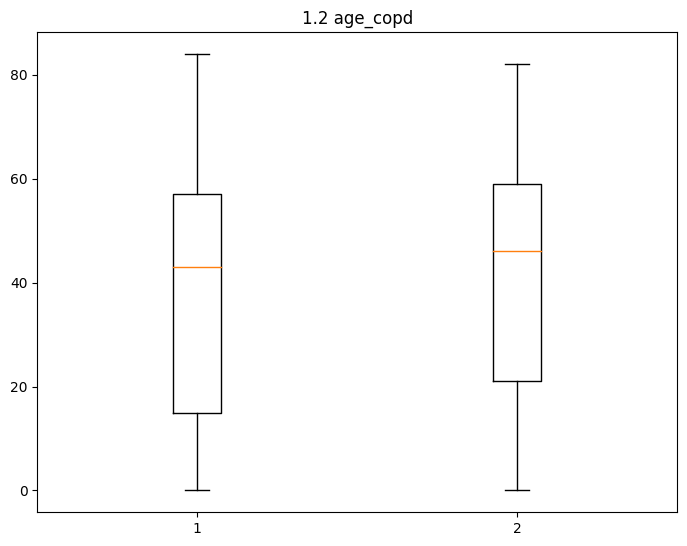

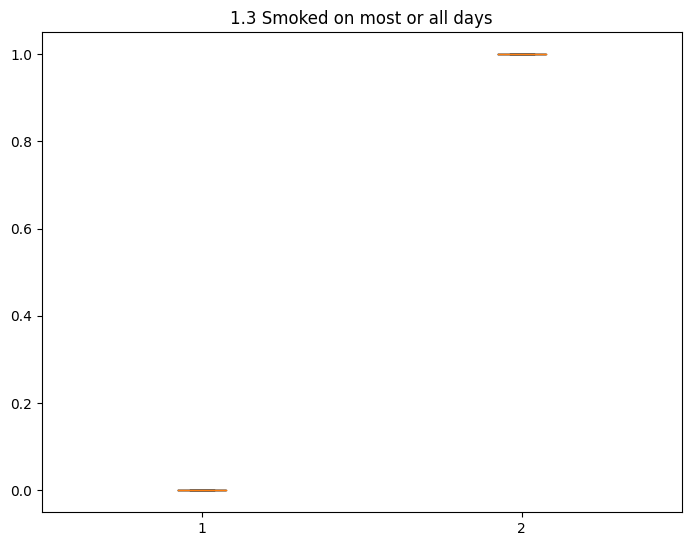

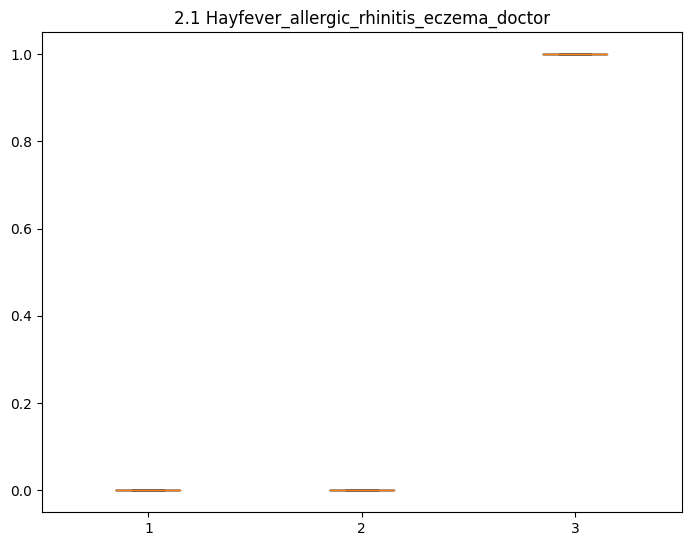

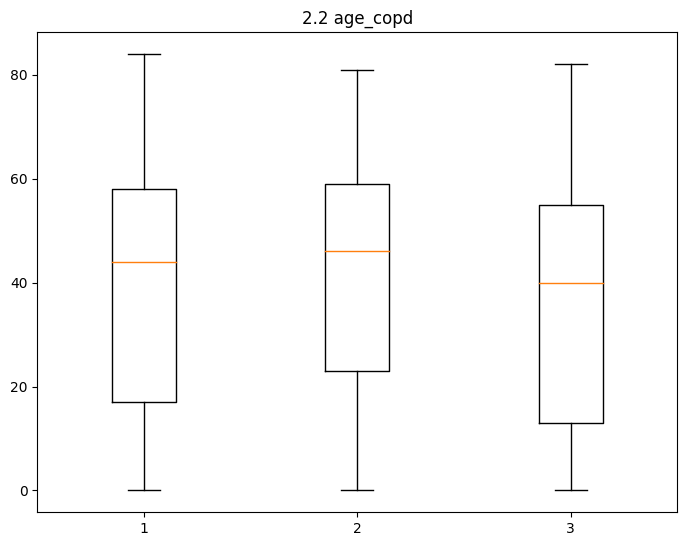

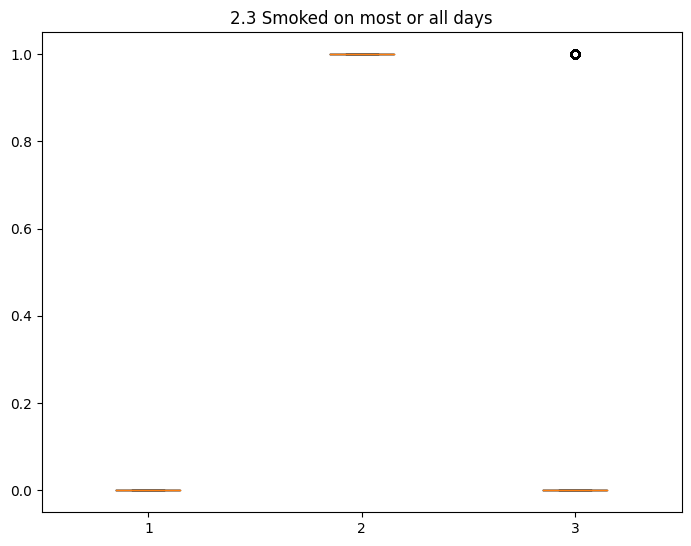

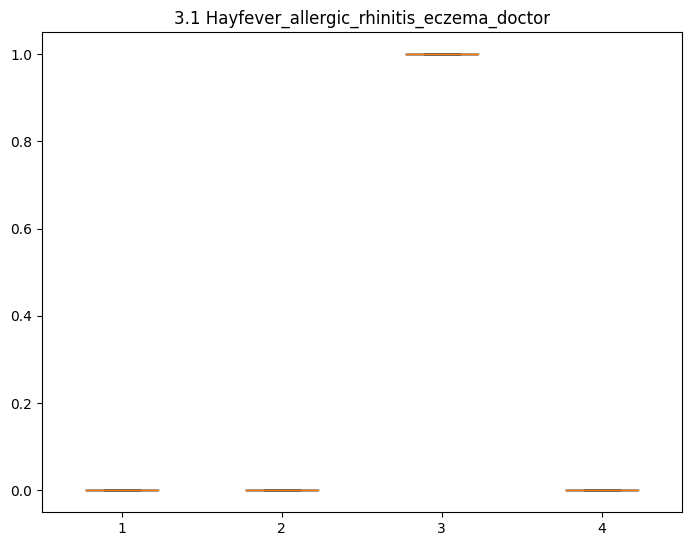

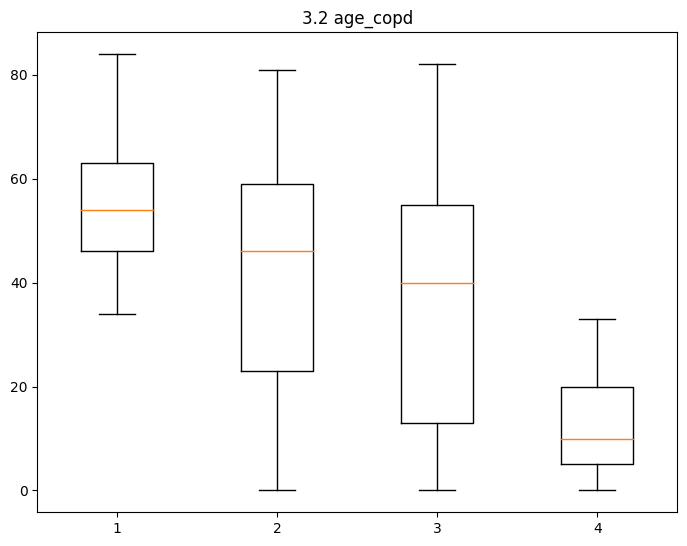

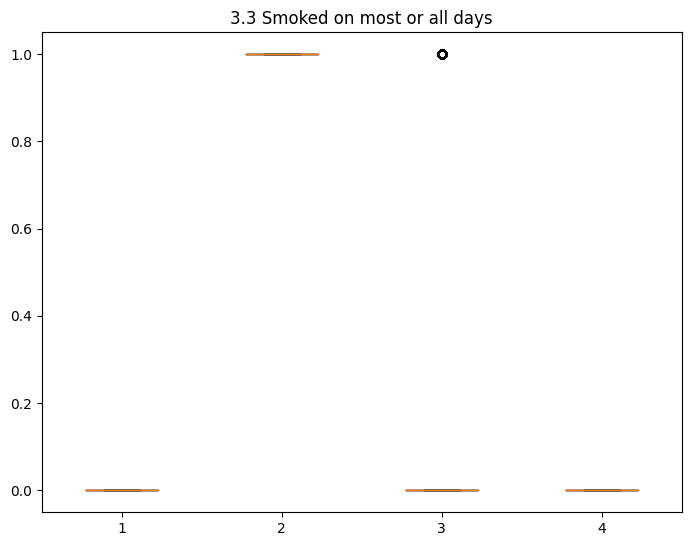

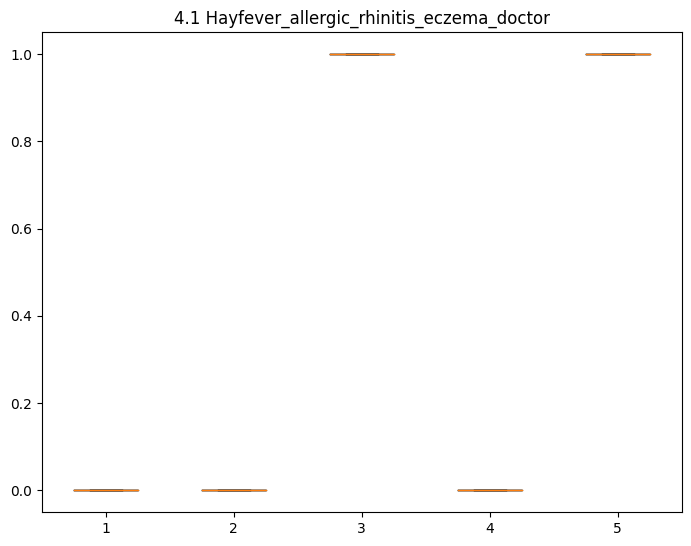

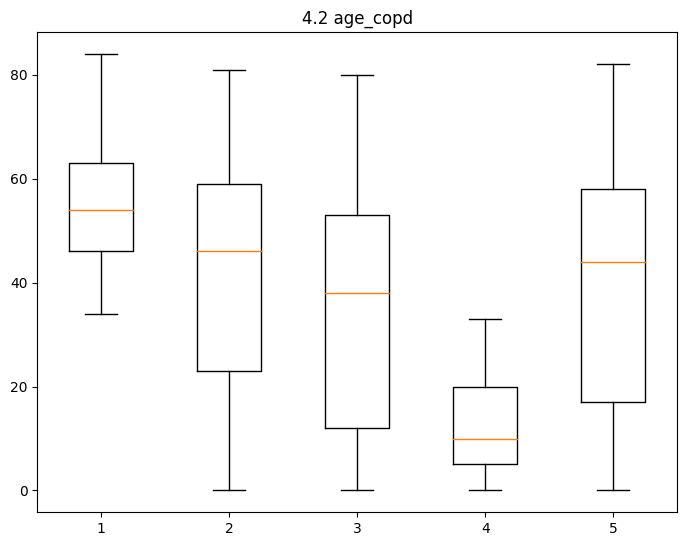

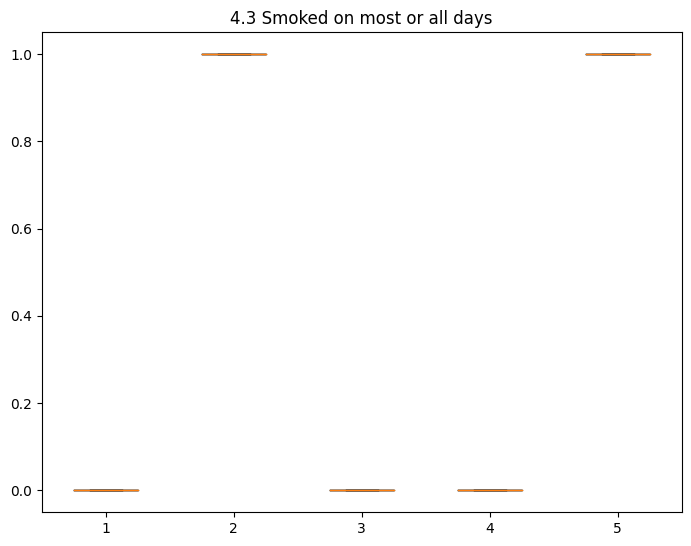

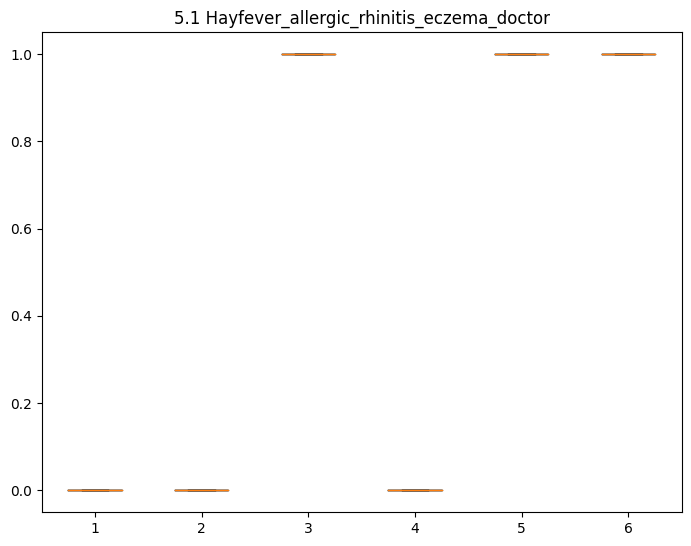

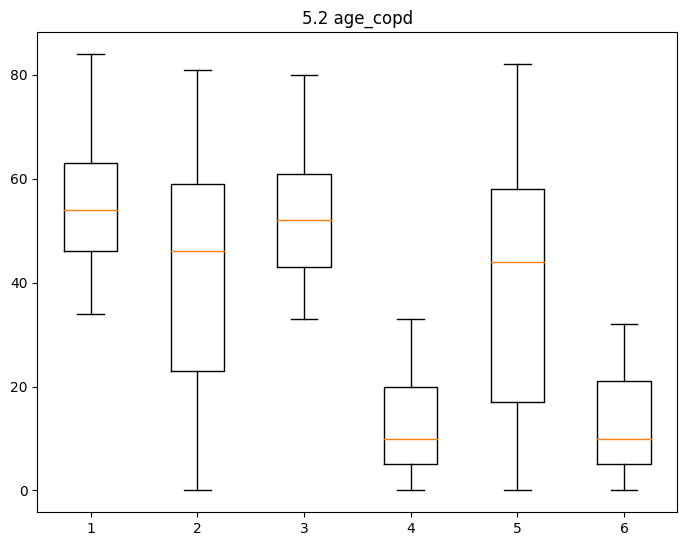

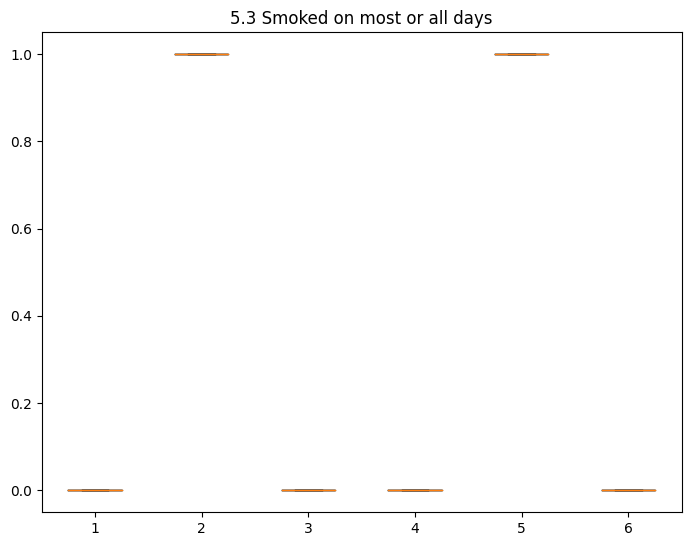

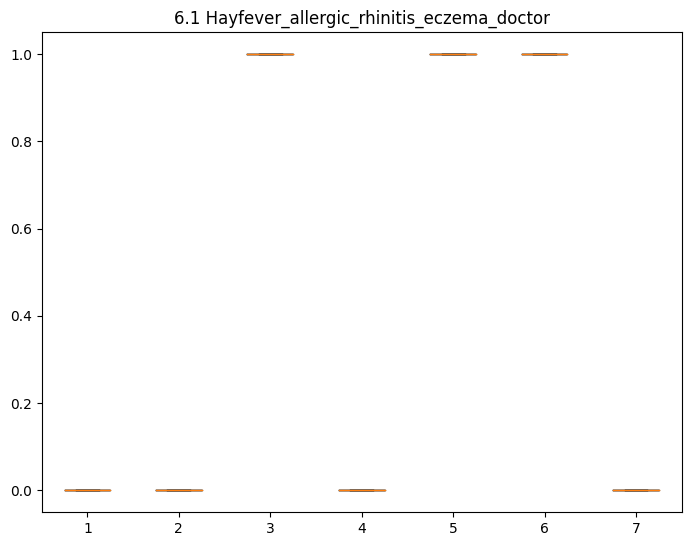

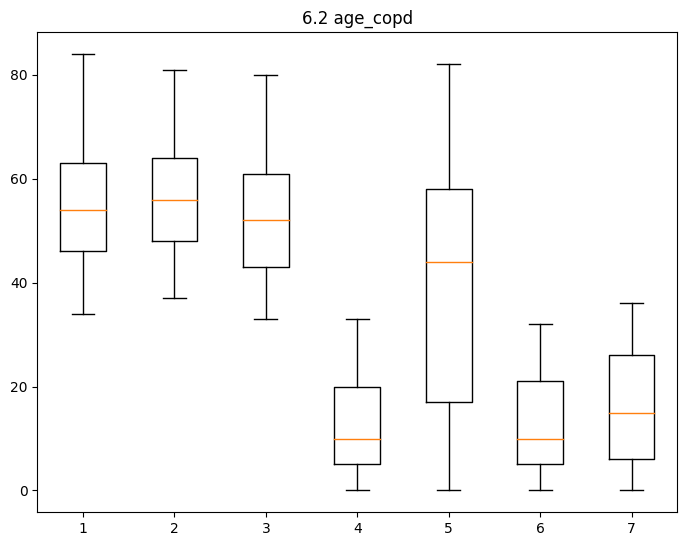

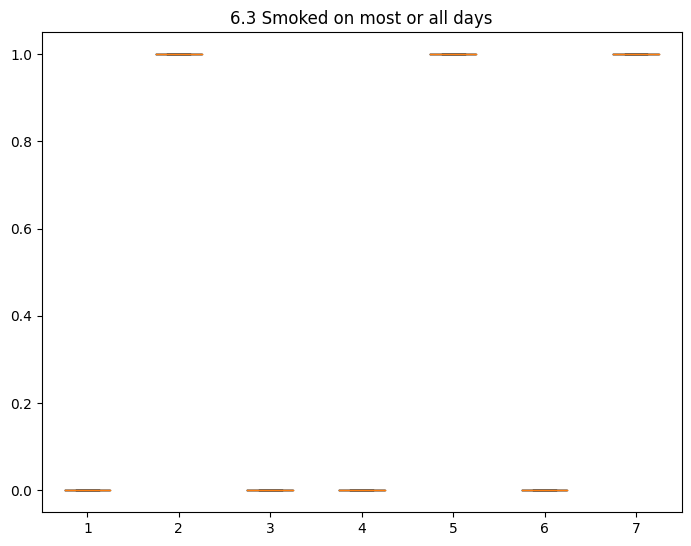

In [117]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=7, wd="C:/Users/keimp/")
qa.cluster_construction_iterative()

x=1
for i in qa.clustered_dfs:
    y=1
    for c in datacolumns_selected:
        d = []
        for j in i:
            d.append(j[c])
        boxplot_timseries(d, str(x)+"."+str(y)+" "+c , abline=False)
        y+=1

    x+=1

In [118]:
x=1
for i in qa.clustered_dfs:
    y=1
    for j in i:
        print(x, ".", y, " ", j.shape)
        y+=1
    x+=1

1 . 1   (7173, 4)
1 . 2   (2815, 4)
2 . 1   (5360, 5)
2 . 2   (2223, 5)
2 . 3   (2405, 5)
3 . 1   (3399, 6)
3 . 2   (2223, 6)
3 . 3   (2405, 6)
3 . 4   (1961, 6)
4 . 1   (3399, 7)
4 . 2   (2223, 7)
4 . 3   (1813, 7)
4 . 4   (1961, 7)
4 . 5   (592, 7)
5 . 1   (3399, 8)
5 . 2   (2223, 8)
5 . 3   (1017, 8)
5 . 4   (1961, 8)
5 . 5   (592, 8)
5 . 6   (796, 8)
6 . 1   (3399, 9)
6 . 2   (1395, 9)
6 . 3   (1017, 9)
6 . 4   (1961, 9)
6 . 5   (592, 9)
6 . 6   (796, 9)
6 . 7   (828, 9)


Other COPD variants in bronchitis 

In [121]:
copd["Date J43 first reported (emphysema)_binary"].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1)].value_counts()

0    9657
1     331
Name: Date J43 first reported (emphysema)_binary, dtype: int64

In [125]:
copd['Date J44 first reported (other chronic obstructive pulmonary disease)_binary'].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1)].value_counts()

0    8170
1    1818
Name: Date J44 first reported (other chronic obstructive pulmonary disease)_binary, dtype: int64

### Clustering emphysema

In [145]:
datacolumns_selected = [
                        "Smoked on most or all days",
                        "Yes, on most or all days"
                       ]

c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:

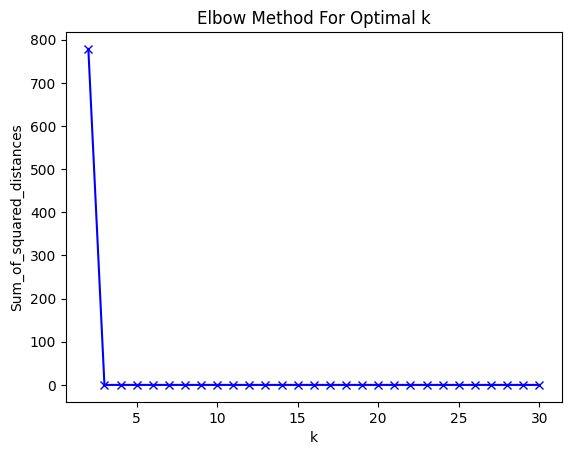

In [146]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J43 first reported (emphysema)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=30, wd="C:/Users/keimp/")
qa.elbow_method()

c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to

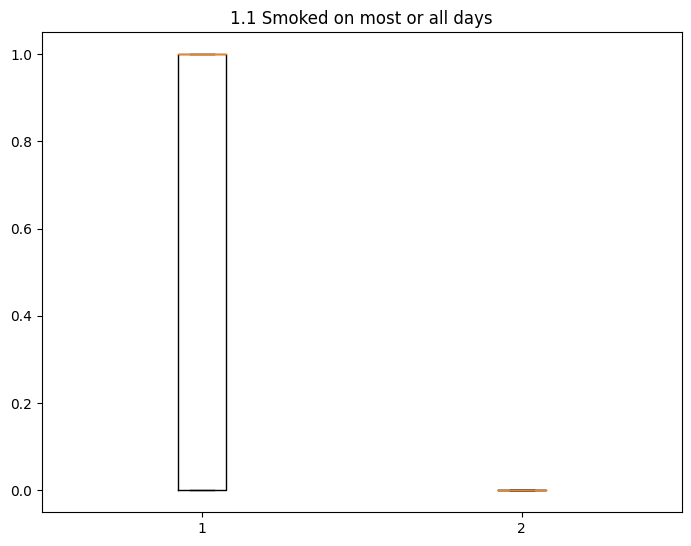

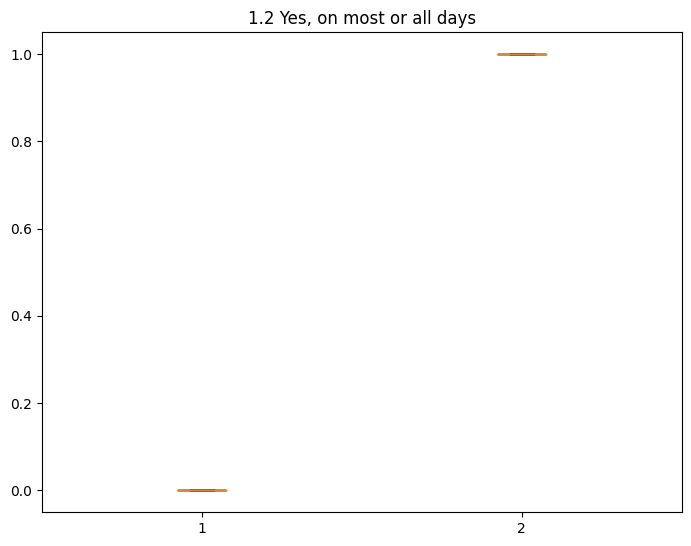

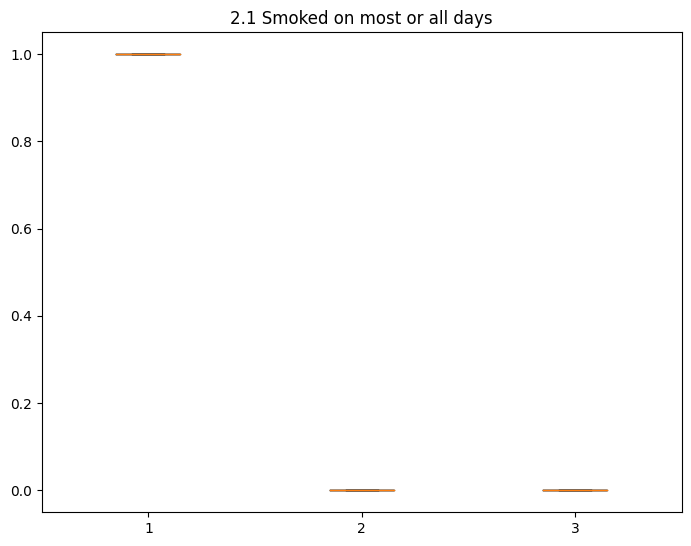

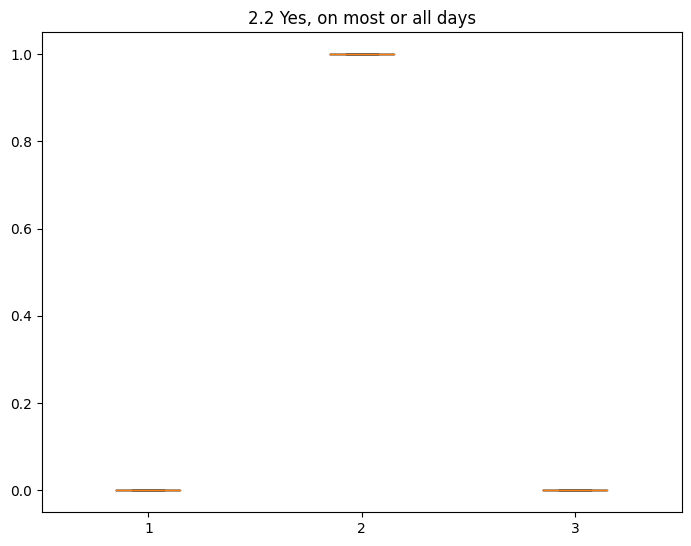

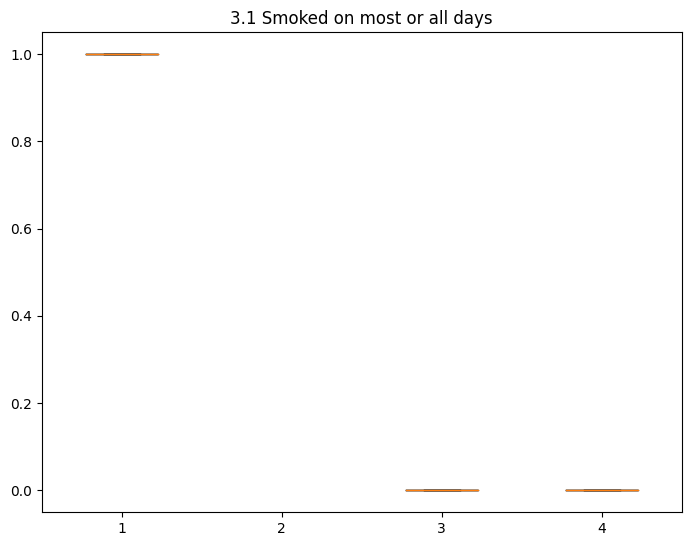

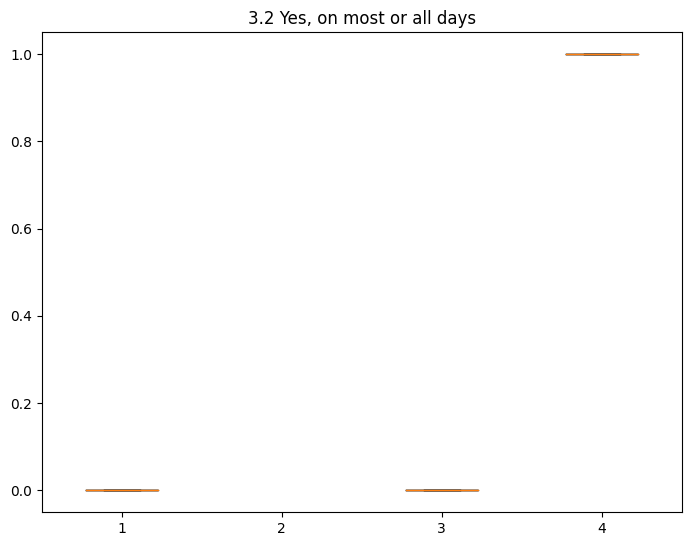

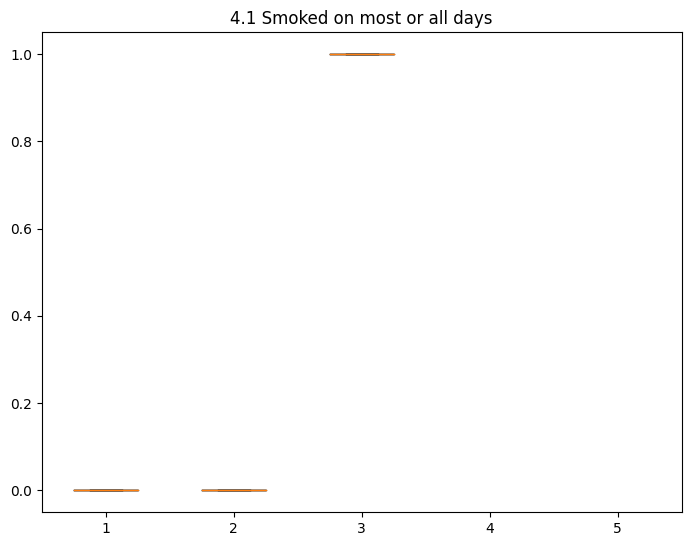

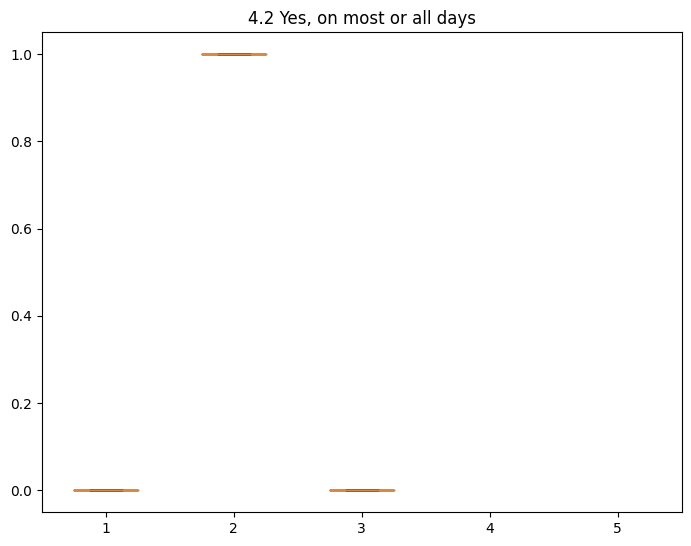

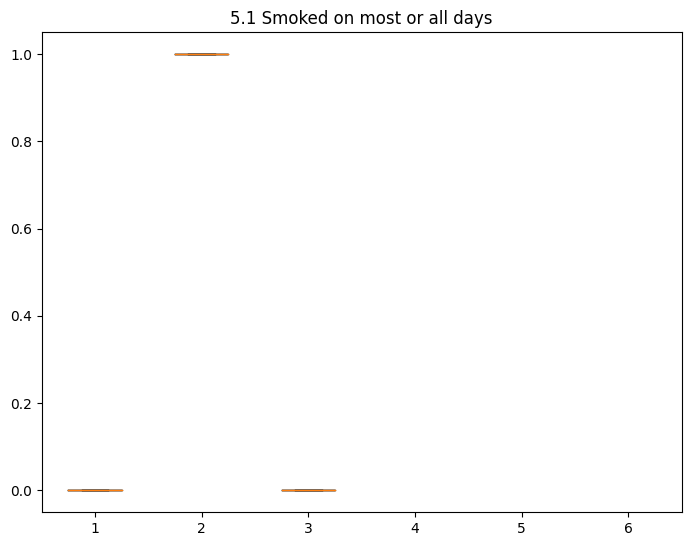

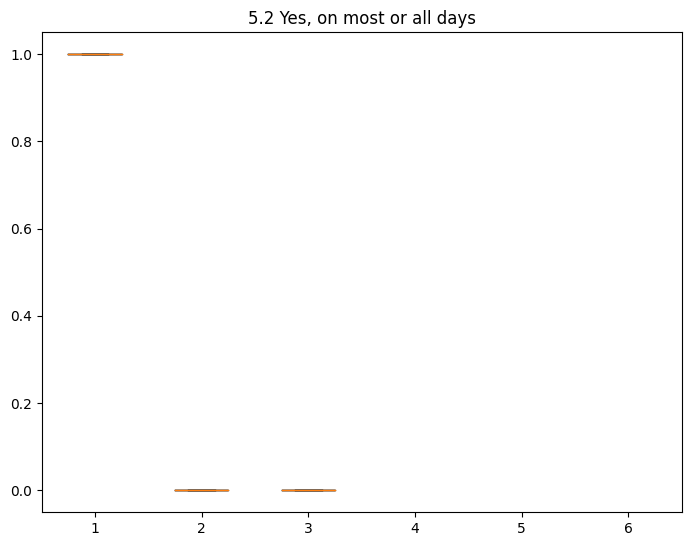

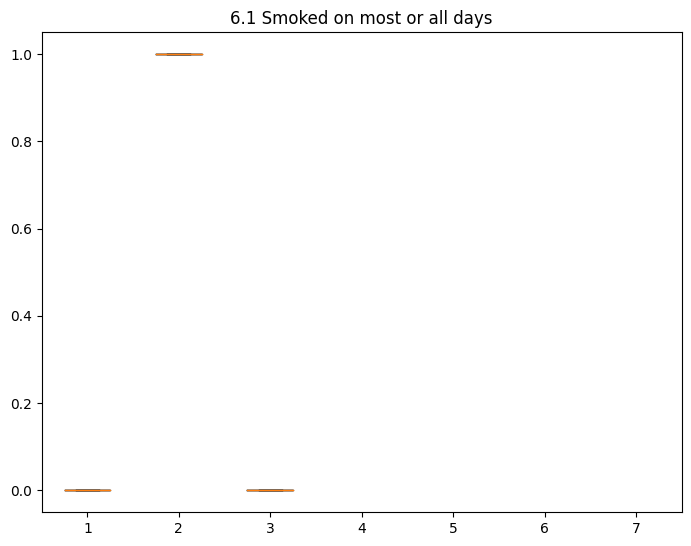

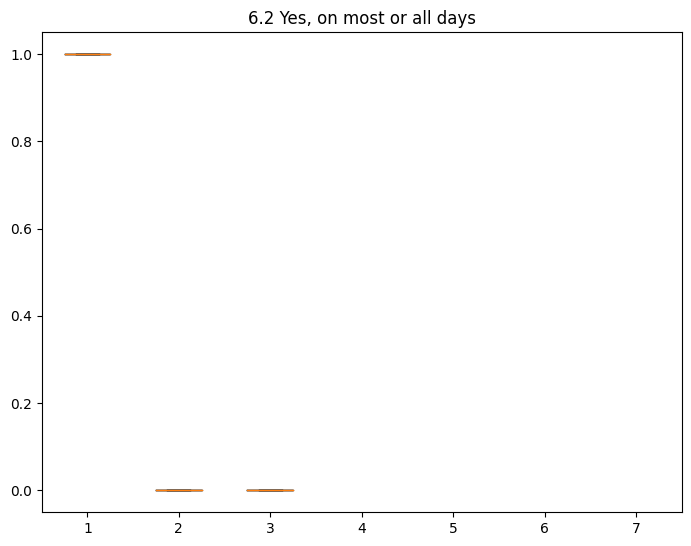

In [147]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J43 first reported (emphysema)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=7, wd="C:/Users/keimp/")
qa.cluster_construction_iterative()

x=1
for i in qa.clustered_dfs:
    y=1
    for c in datacolumns_selected:
        d = []
        for j in i:
            d.append(j[c])
        boxplot_timseries(d, str(x)+"."+str(y)+" "+c , abline=False)
        y+=1

    x+=1

In [148]:
x=1
for i in qa.clustered_dfs:
    y=1
    for j in i:
        print(x, ".", y, " ", j.shape)
        y+=1
    x+=1

1 . 1   (3841, 3)
1 . 2   (2165, 3)
2 . 1   (2756, 4)
2 . 2   (2165, 4)
2 . 3   (1085, 4)
3 . 1   (2756, 5)
3 . 2   (0, 5)
3 . 3   (1085, 5)
3 . 4   (2165, 5)
4 . 1   (1085, 6)
4 . 2   (2165, 6)
4 . 3   (2756, 6)
4 . 4   (0, 6)
4 . 5   (0, 6)
5 . 1   (2165, 7)
5 . 2   (2756, 7)
5 . 3   (1085, 7)
5 . 4   (0, 7)
5 . 5   (0, 7)
5 . 6   (0, 7)
6 . 1   (2165, 8)
6 . 2   (2756, 8)
6 . 3   (1085, 8)
6 . 4   (0, 8)
6 . 5   (0, 8)
6 . 6   (0, 8)
6 . 7   (0, 8)


### Bronchitis clustering with past and current smoking

In [165]:
datacolumns_selected = [
                        "Smoked on most or all days",
                        "Yes, on most or all days",
                        "age_copd"
                       ]

c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\

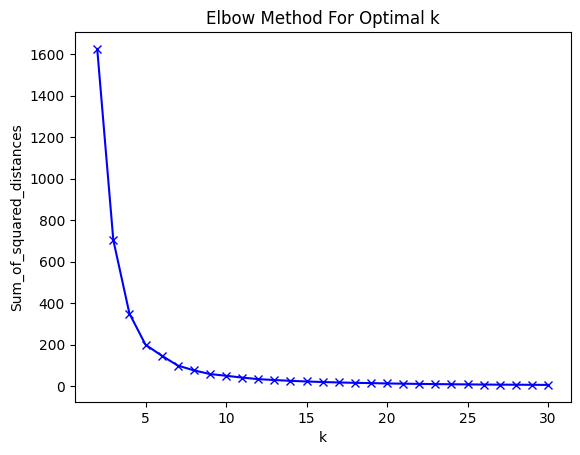

In [166]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=30, wd="C:/Users/keimp/")
qa.elbow_method()

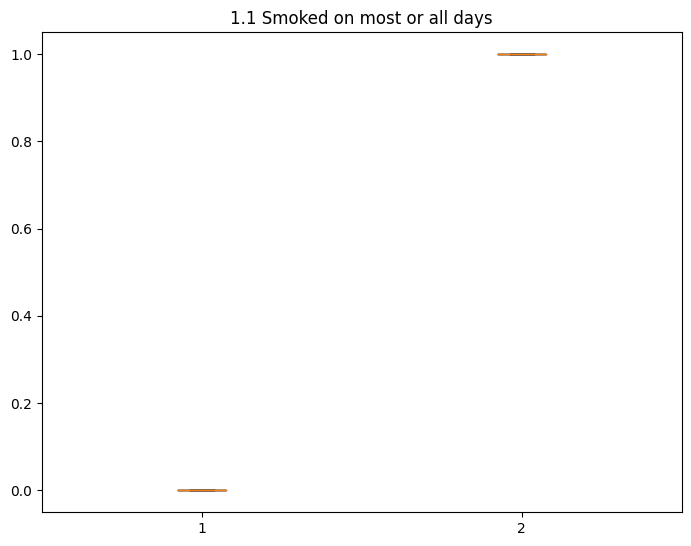

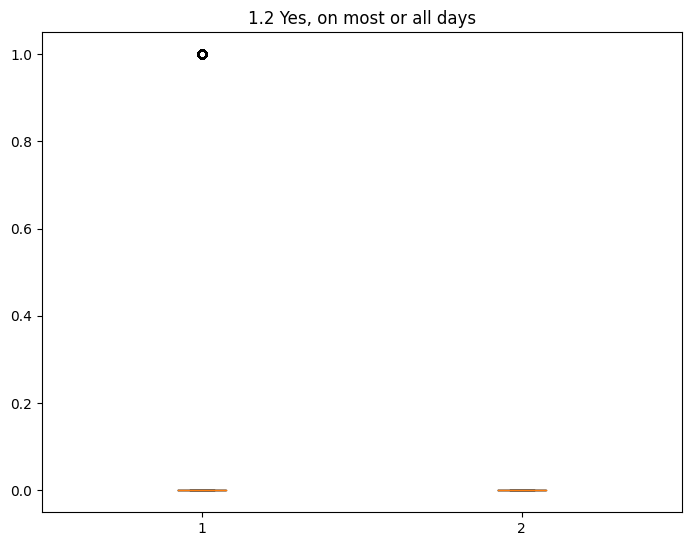

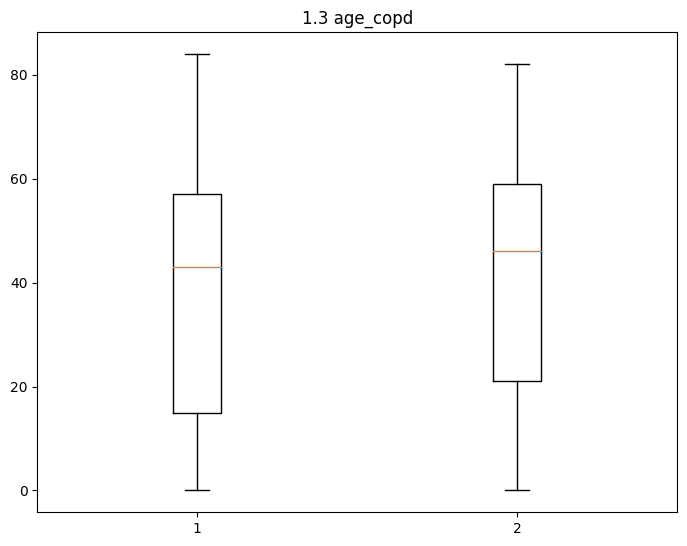

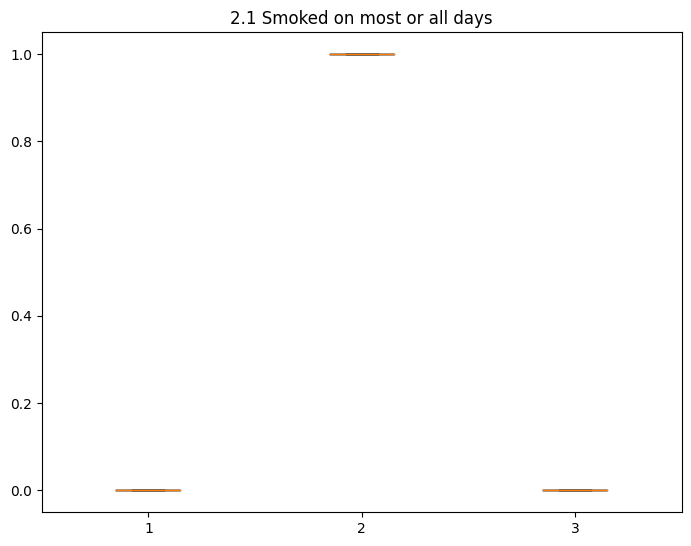

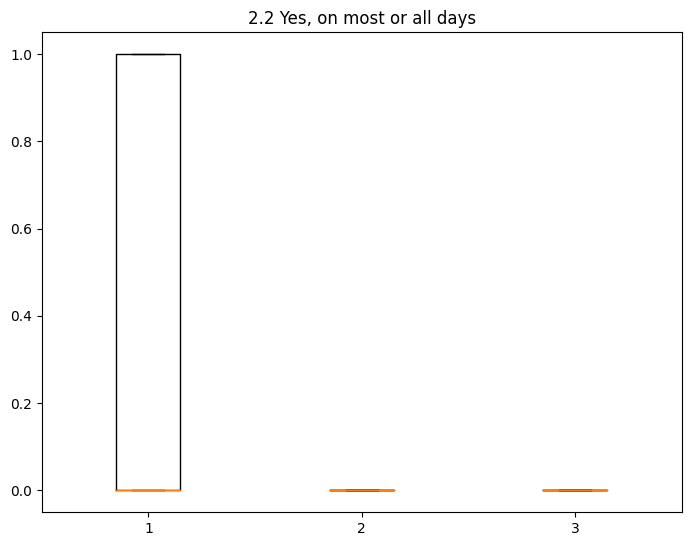

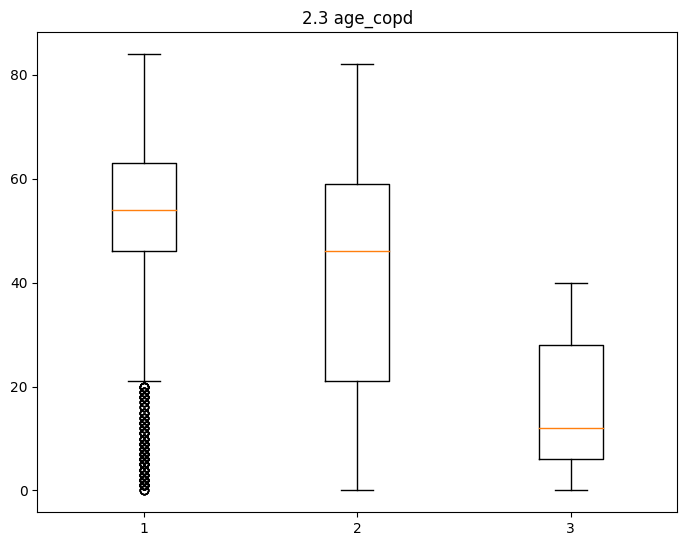

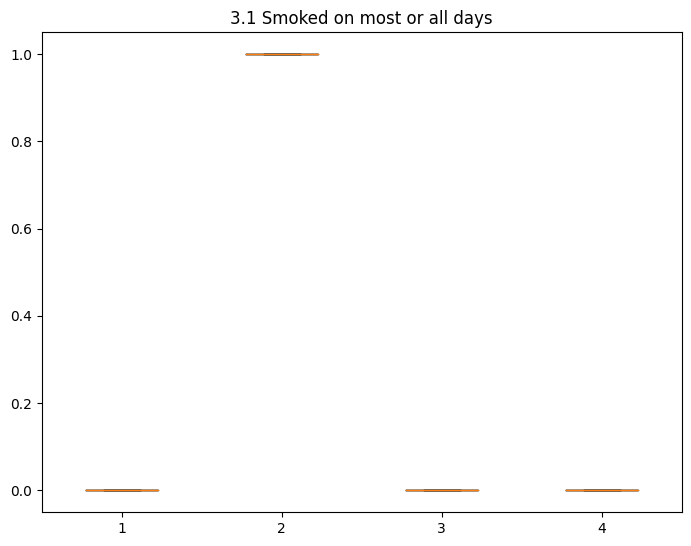

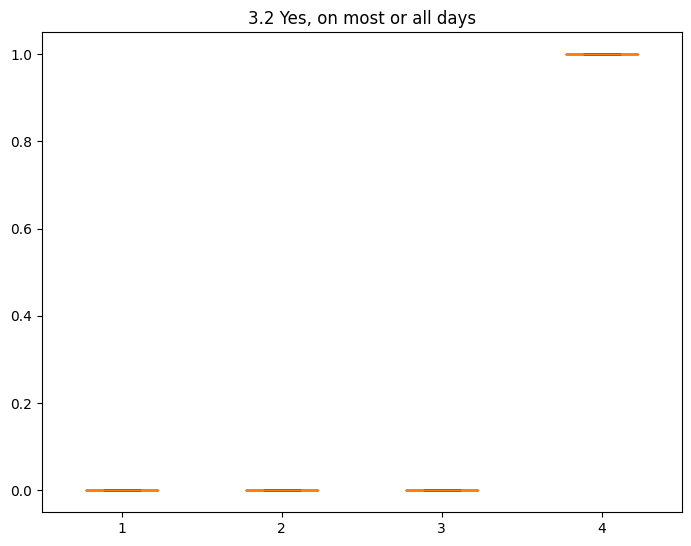

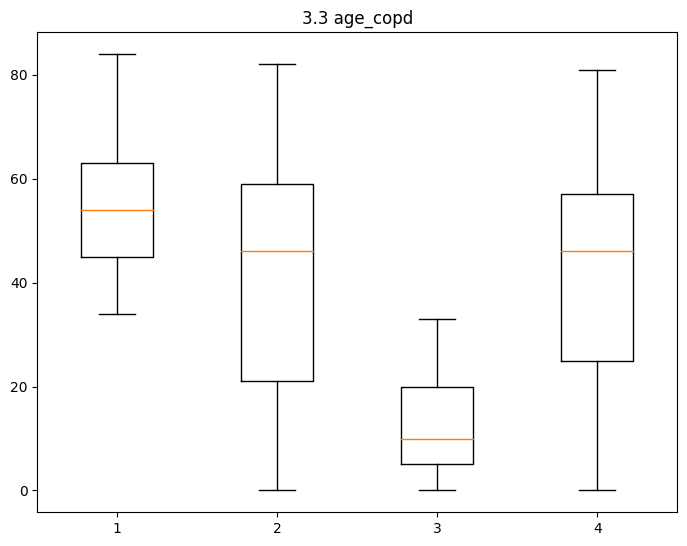

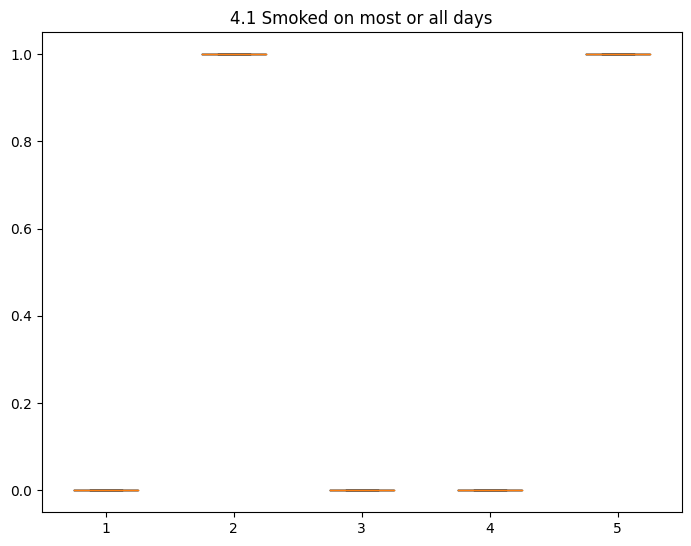

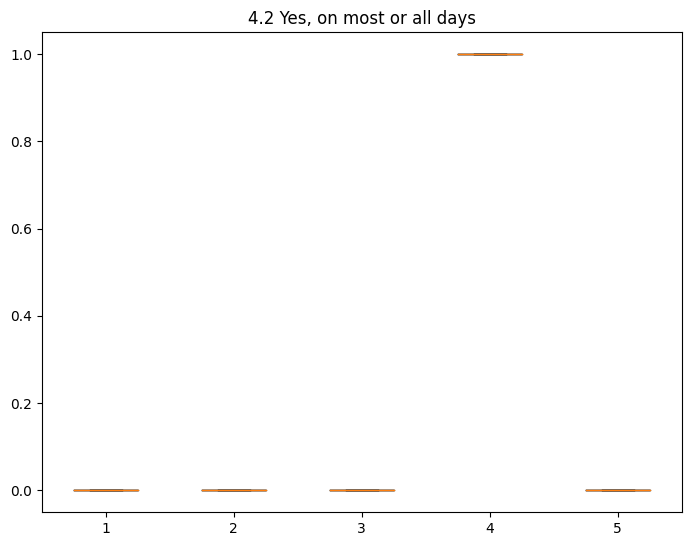

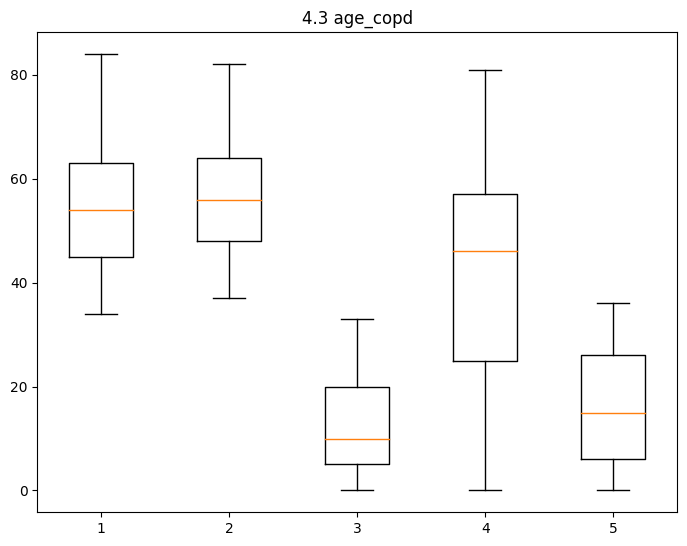

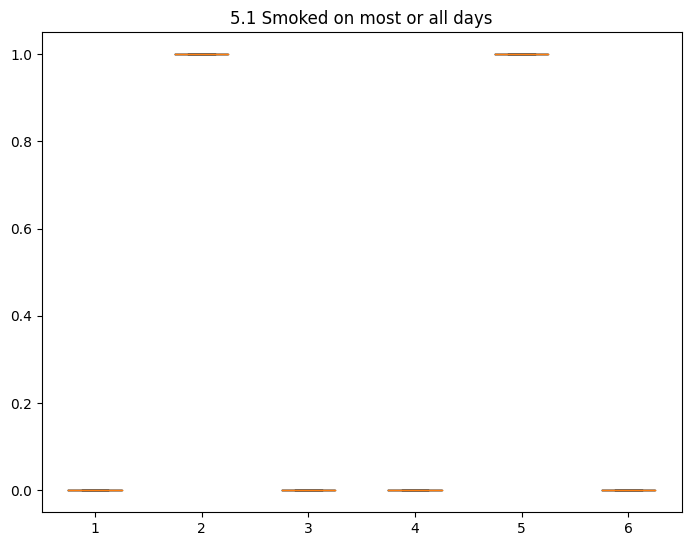

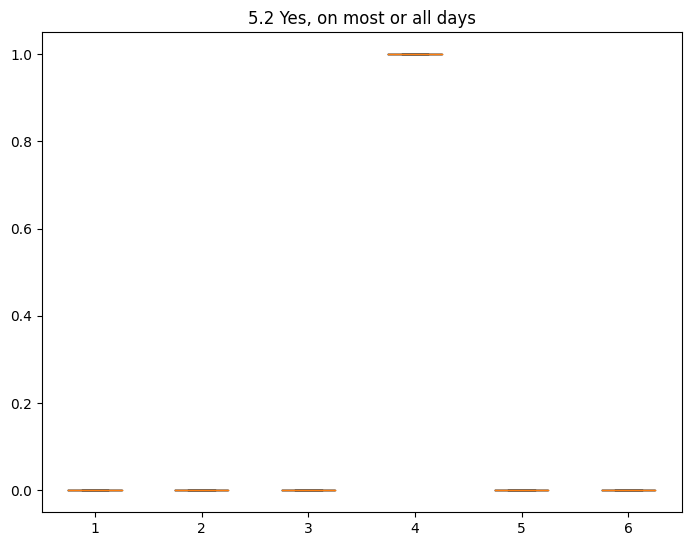

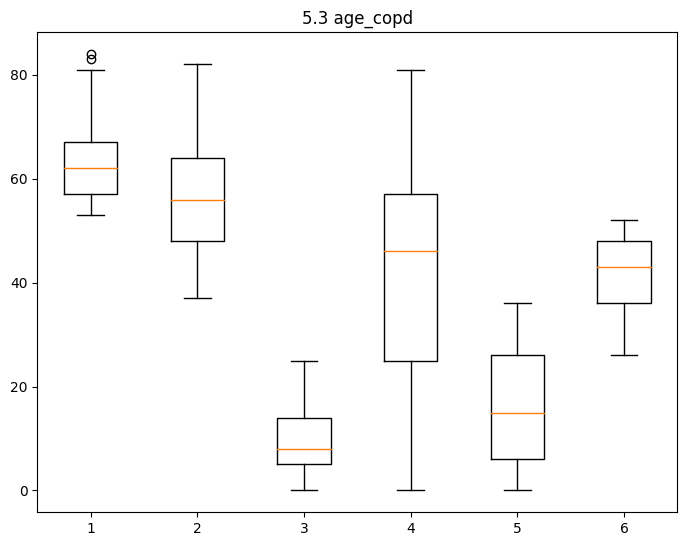

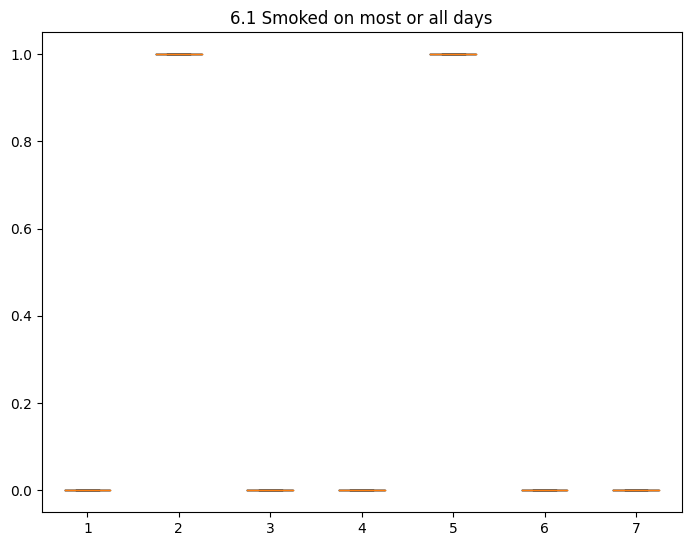

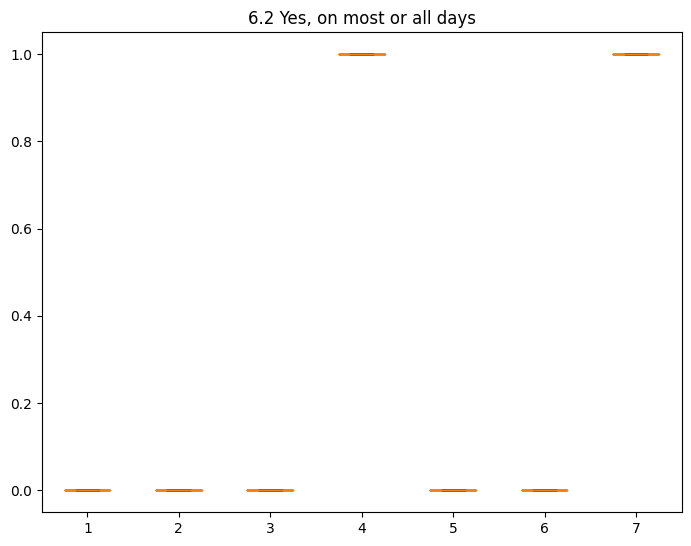

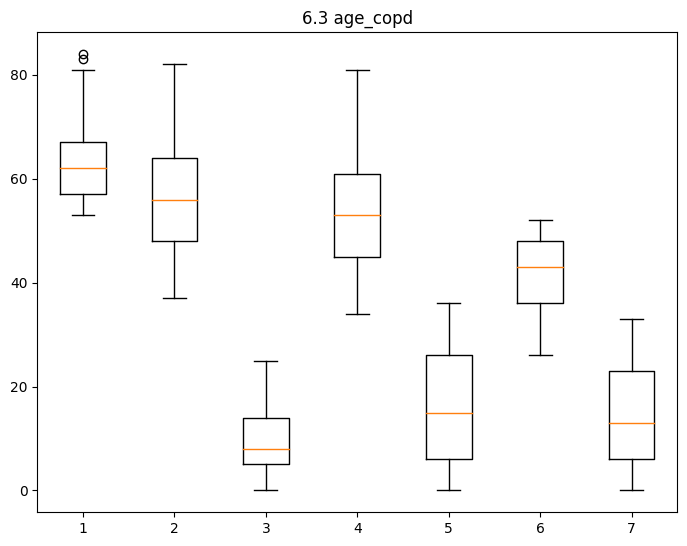

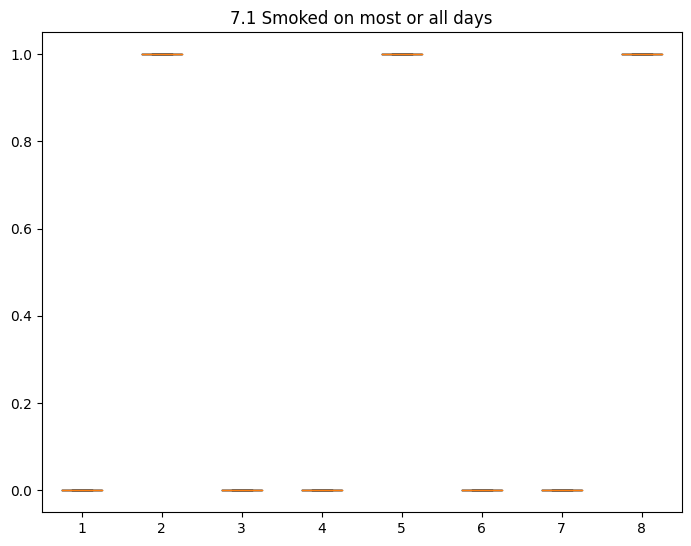

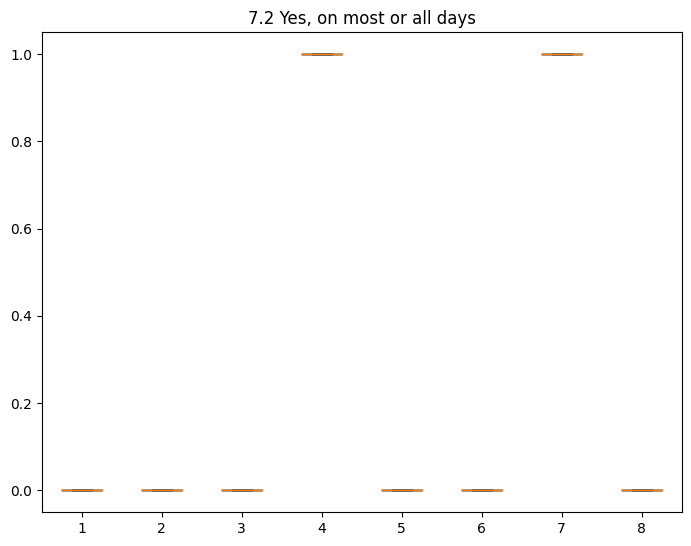

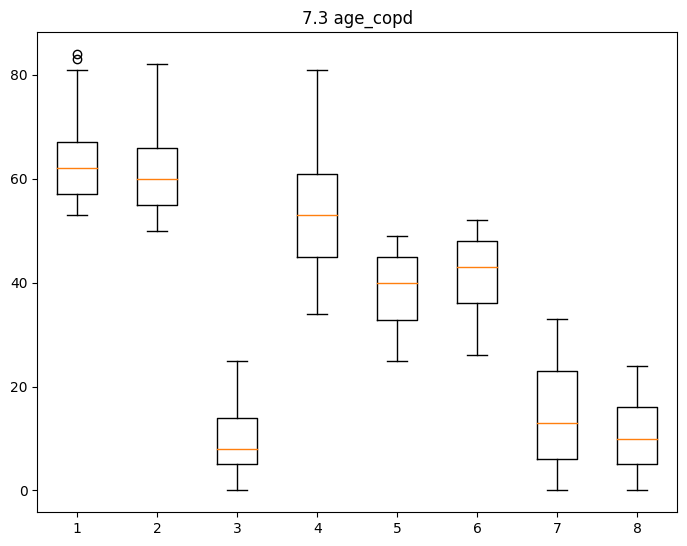

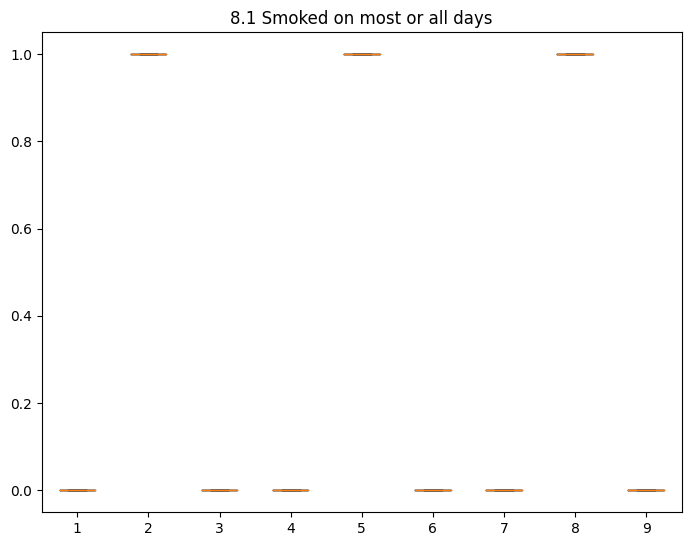

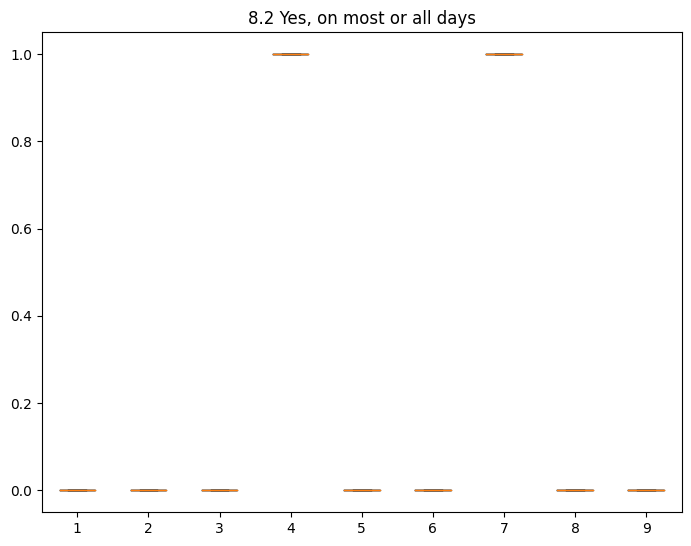

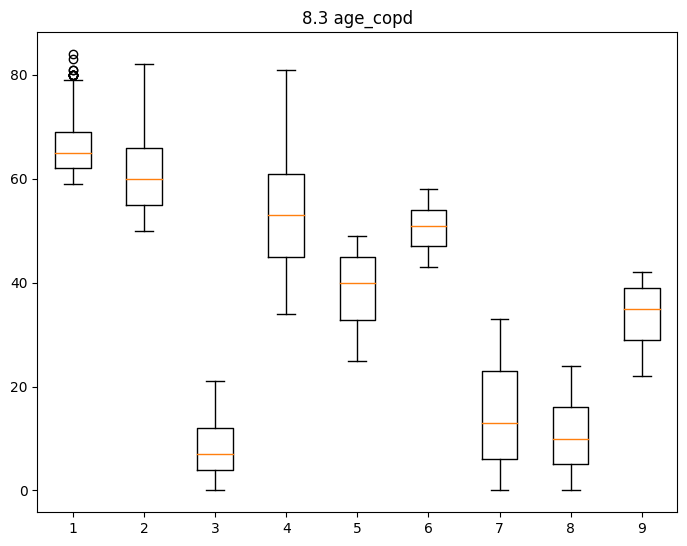

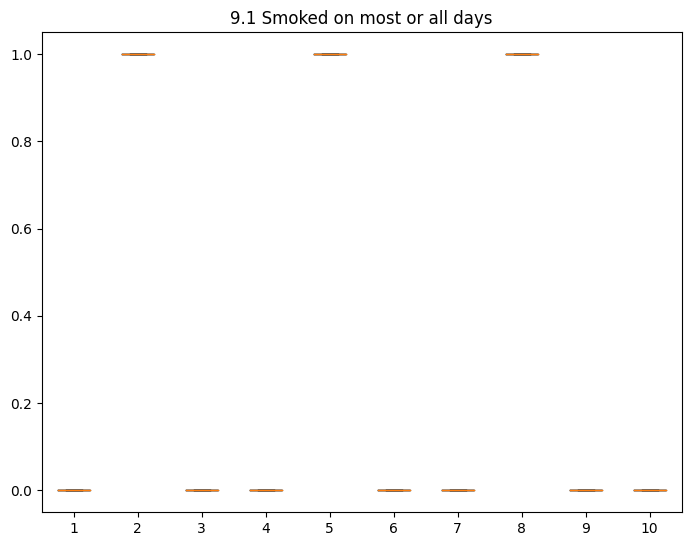

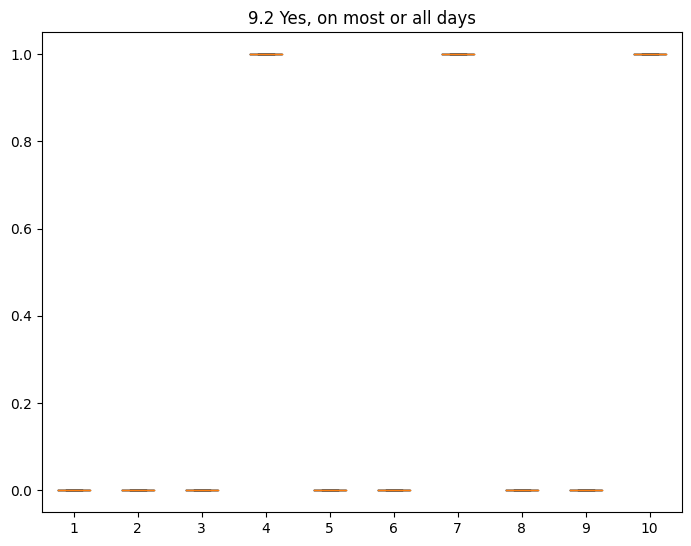

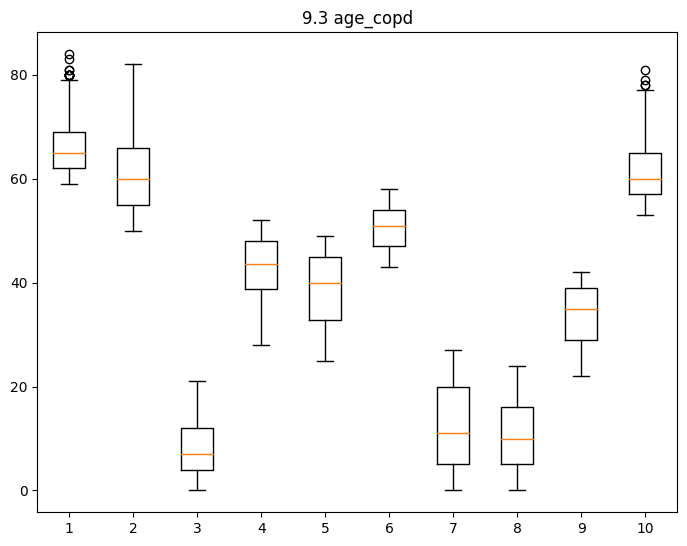

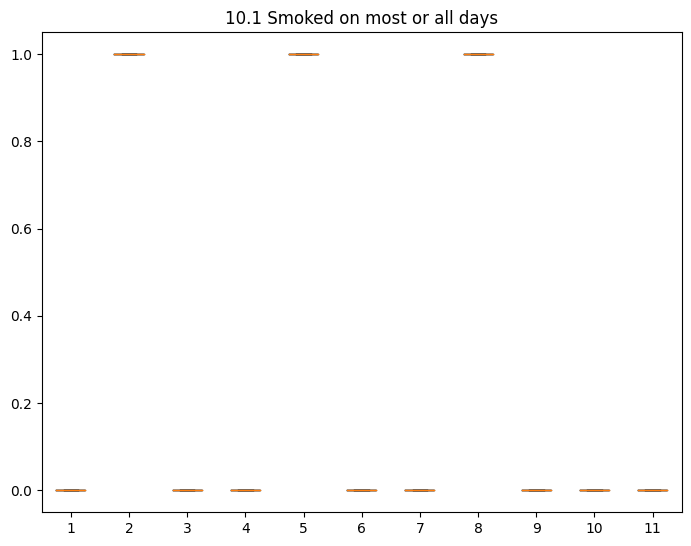

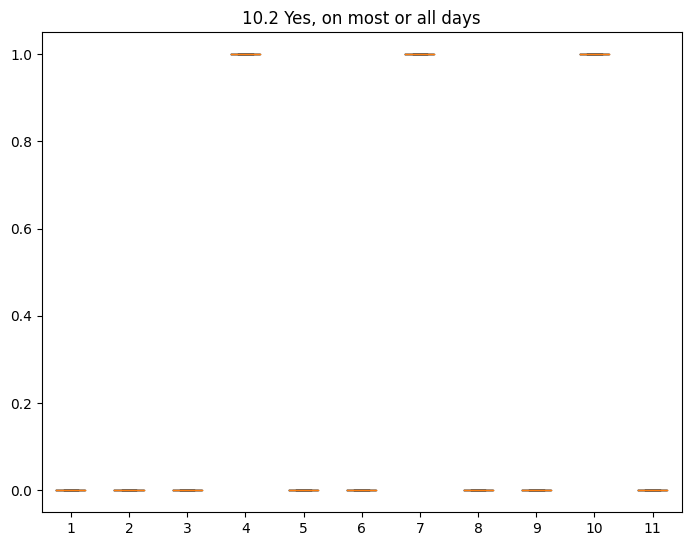

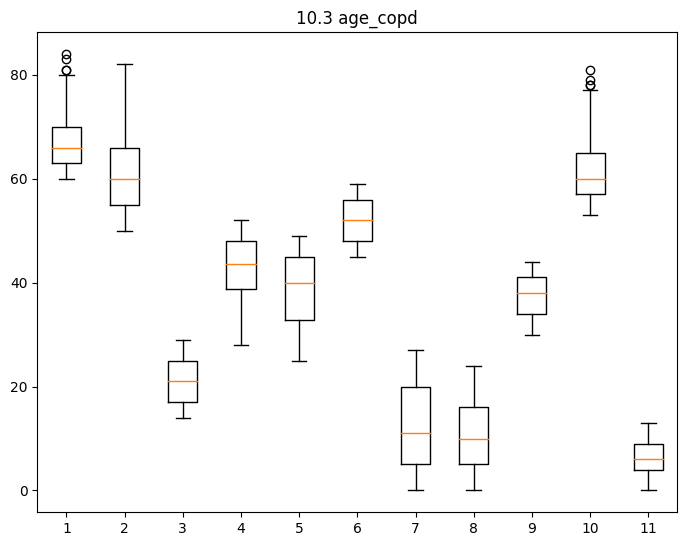

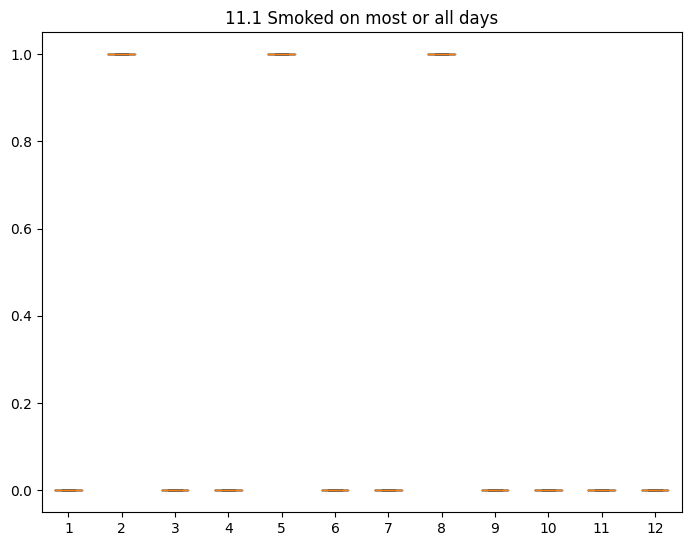

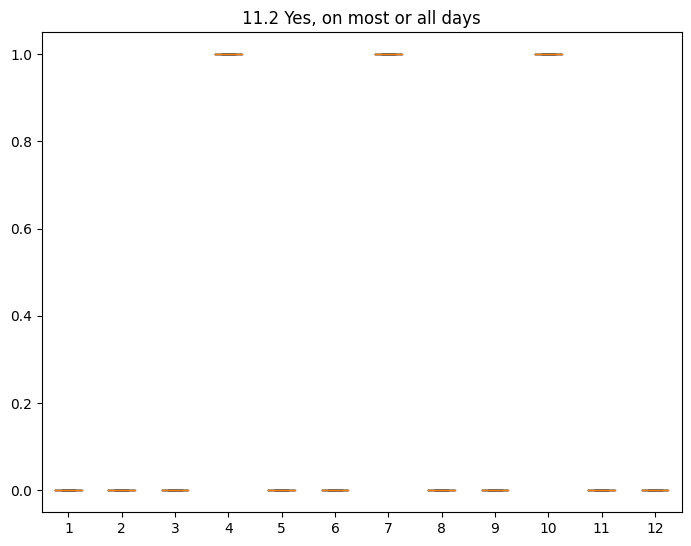

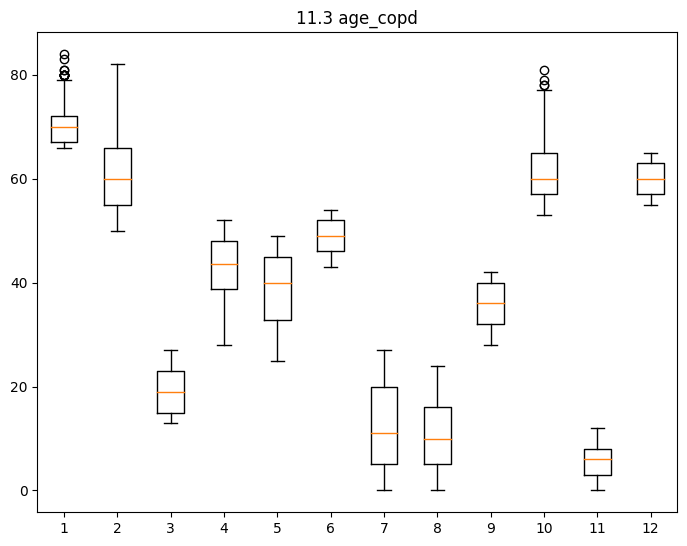

In [167]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J40 first reported (bronchitis, not specified as acute or chronic)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=12, wd="C:/Users/keimp/")
qa.cluster_construction_iterative()

x=1
for i in qa.clustered_dfs:
    y=1
    for c in datacolumns_selected:
        d = []
        for j in i:
            d.append(j[c])
        boxplot_timseries(d, str(x)+"."+str(y)+" "+c , abline=False)
        y+=1

    x+=1

In [168]:
x=1
for i in qa.clustered_dfs:
    y=1
    for j in i:
        print(x, ".", y, " ", j.shape)
        y+=1
    x+=1

1 . 1   (7173, 4)
1 . 2   (2815, 4)
2 . 1   (4272, 5)
2 . 2   (2815, 5)
2 . 3   (2901, 5)
3 . 1   (3650, 6)
3 . 2   (2815, 6)
3 . 3   (2440, 6)
3 . 4   (1083, 6)
4 . 1   (3650, 7)
4 . 2   (1739, 7)
4 . 3   (2440, 7)
4 . 4   (1083, 7)
4 . 5   (1076, 7)
5 . 1   (1948, 8)
5 . 2   (1739, 8)
5 . 3   (2054, 8)
5 . 4   (1083, 8)
5 . 5   (1076, 8)
5 . 6   (2088, 8)
6 . 1   (1948, 9)
6 . 2   (1739, 9)
6 . 3   (2054, 9)
6 . 4   (746, 9)
6 . 5   (1076, 9)
6 . 6   (2088, 9)
6 . 7   (337, 9)
7 . 1   (1948, 10)
7 . 2   (1240, 10)
7 . 3   (2054, 10)
7 . 4   (746, 10)
7 . 5   (800, 10)
7 . 6   (2088, 10)
7 . 7   (337, 10)
7 . 8   (775, 10)
8 . 1   (1344, 11)
8 . 2   (1240, 11)
8 . 3   (1895, 11)
8 . 4   (746, 11)
8 . 5   (800, 11)
8 . 6   (1663, 11)
8 . 7   (337, 11)
8 . 8   (775, 11)
8 . 9   (1188, 11)
9 . 1   (1344, 12)
9 . 2   (1240, 12)
9 . 3   (1895, 12)
9 . 4   (416, 12)
9 . 5   (800, 12)
9 . 6   (1663, 12)
9 . 7   (288, 12)
9 . 8   (775, 12)
9 . 9   (1188, 12)
9 . 10   (379, 12)
10 . 1   (1235,

### Other COPD clustering

In [172]:
datacolumns_selected = [
                        "Smoked on most or all days",
                        "Yes, on most or all days"
                       ]

c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:

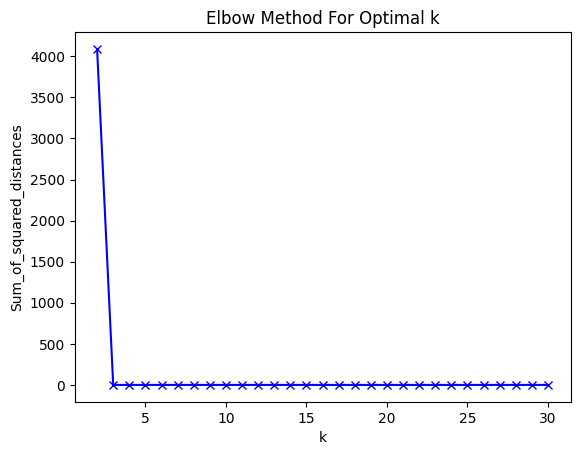

In [173]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=30, wd="C:/Users/keimp/")
qa.elbow_method()

c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\users\keimp\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:1152: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to

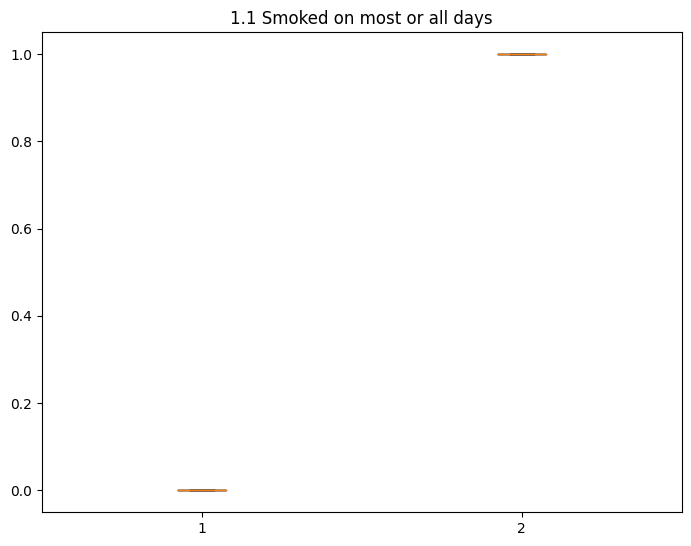

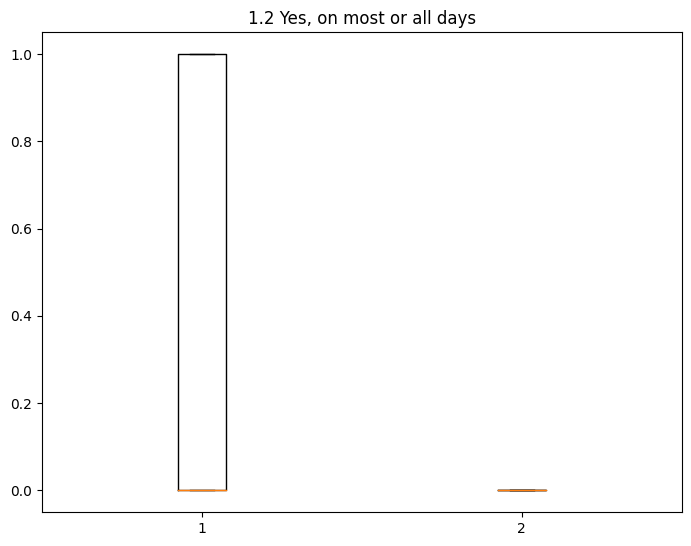

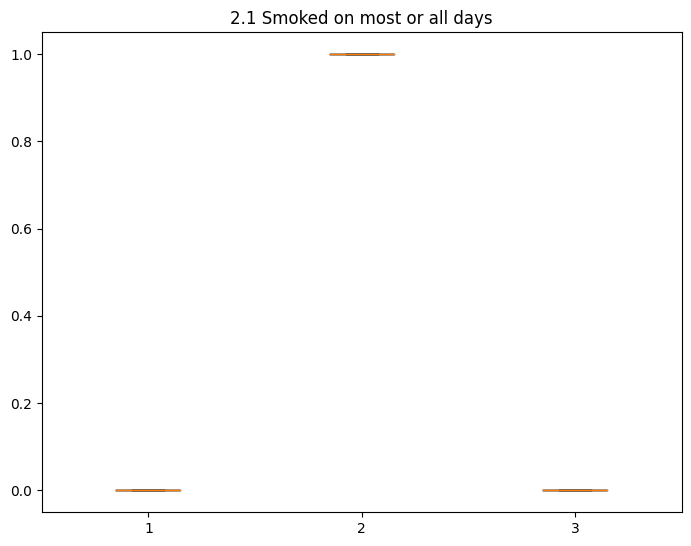

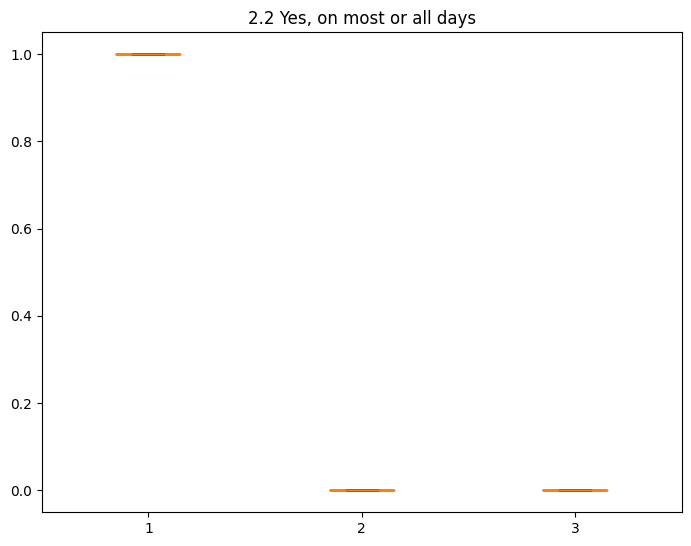

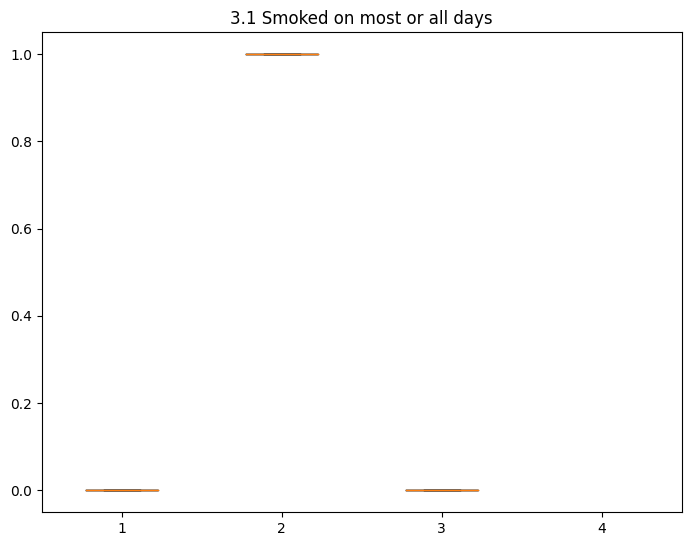

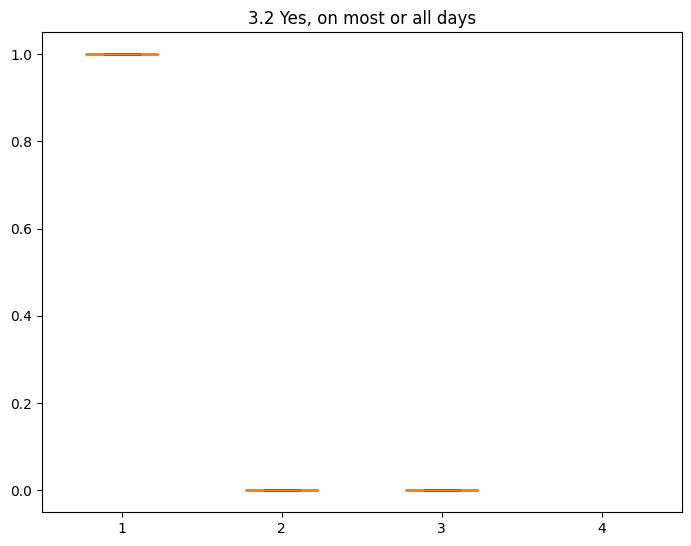

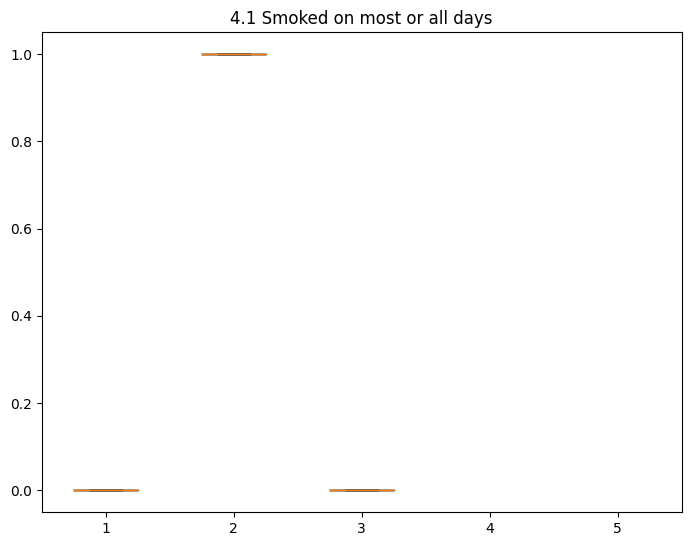

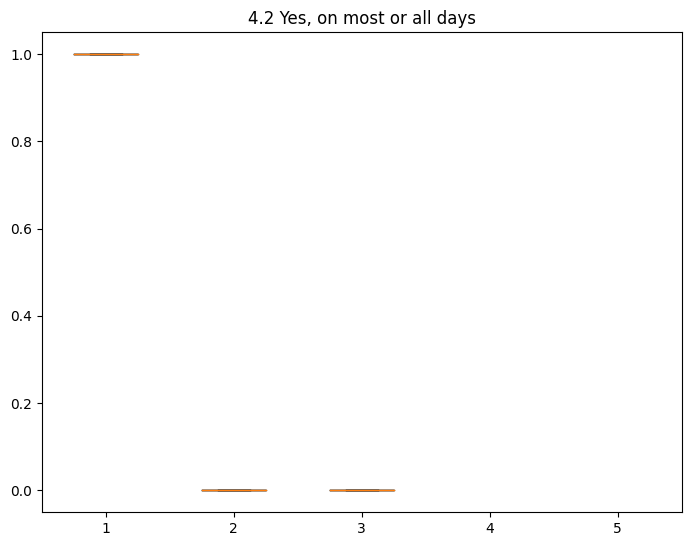

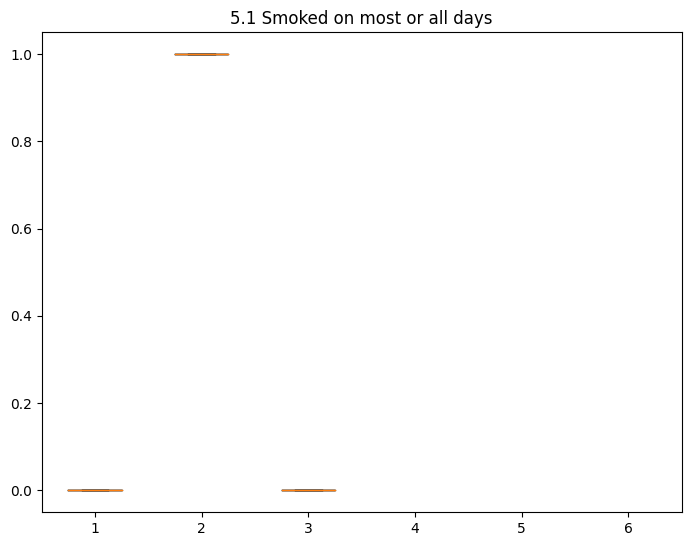

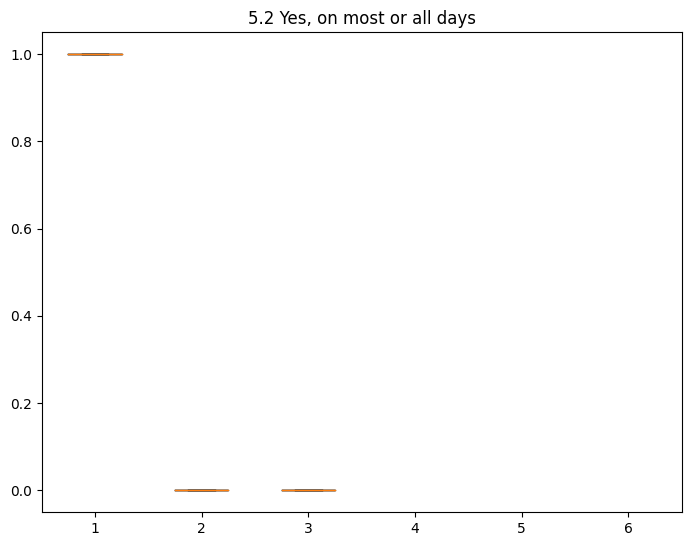

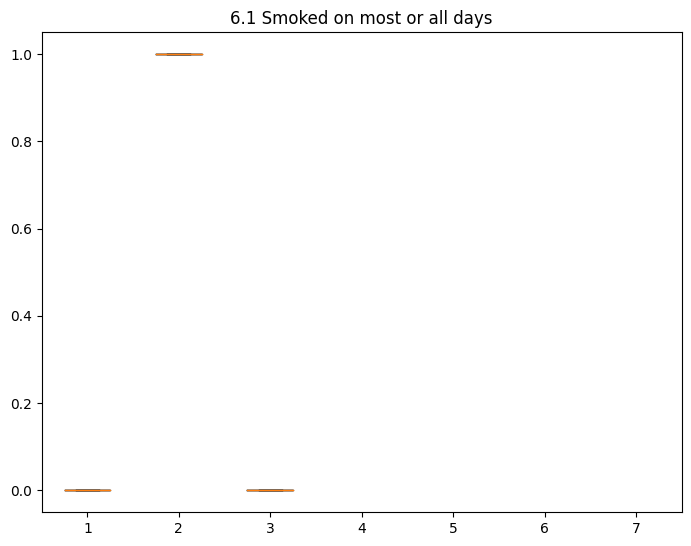

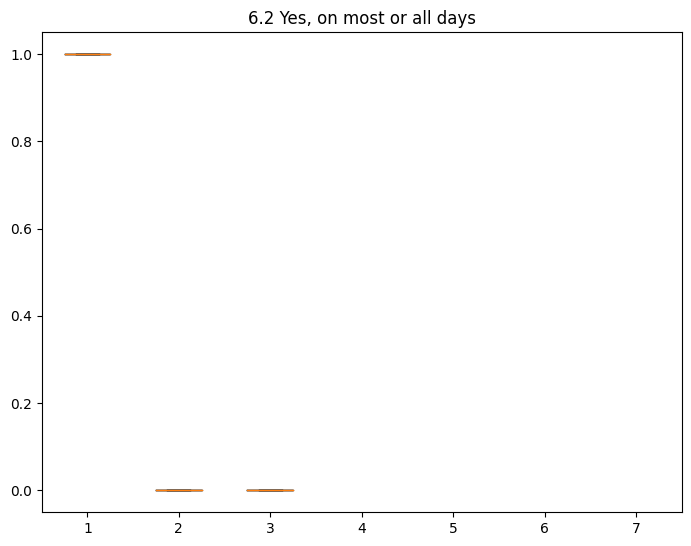

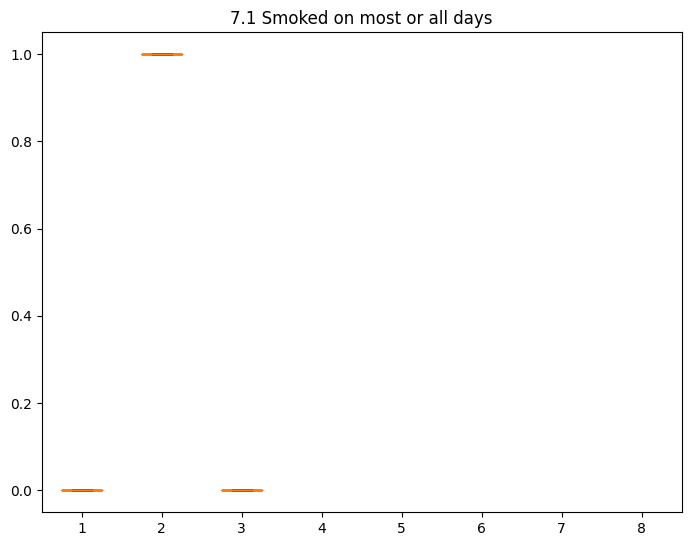

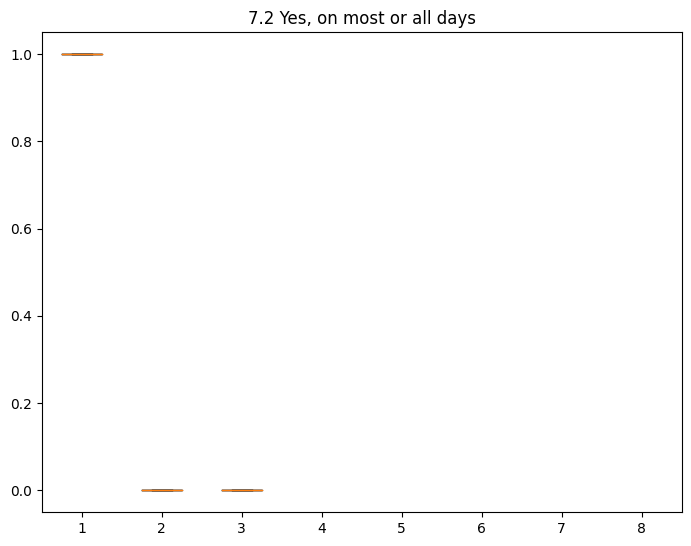

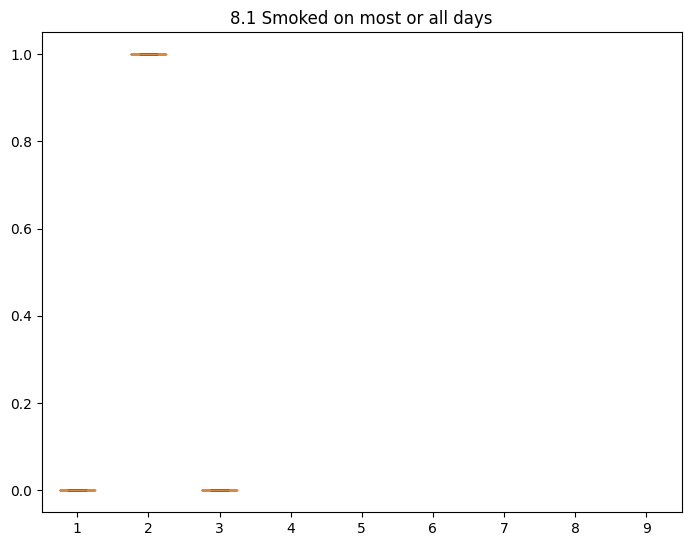

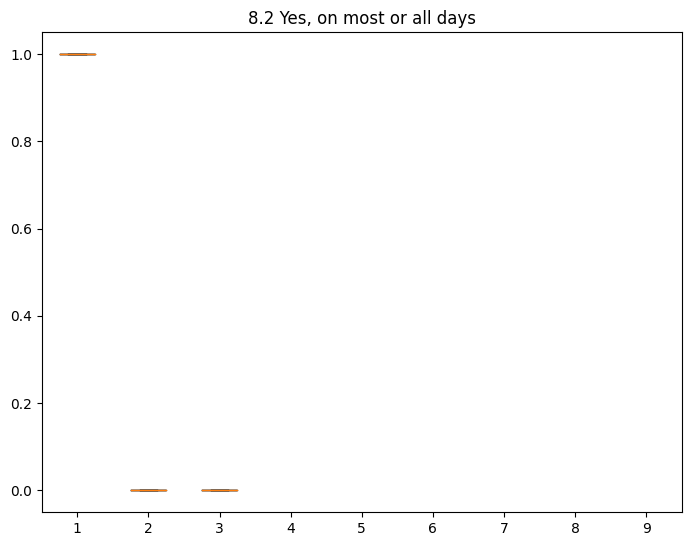

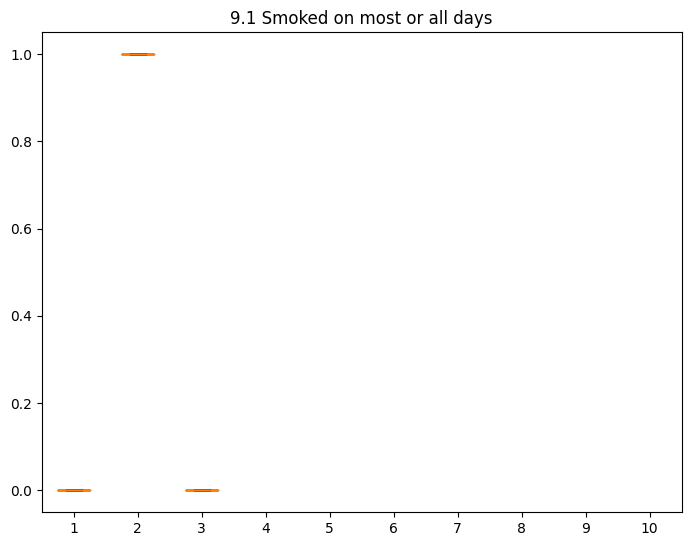

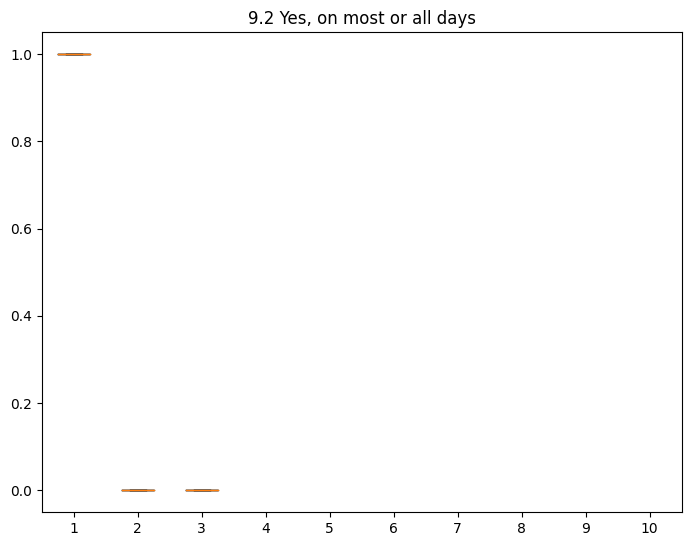

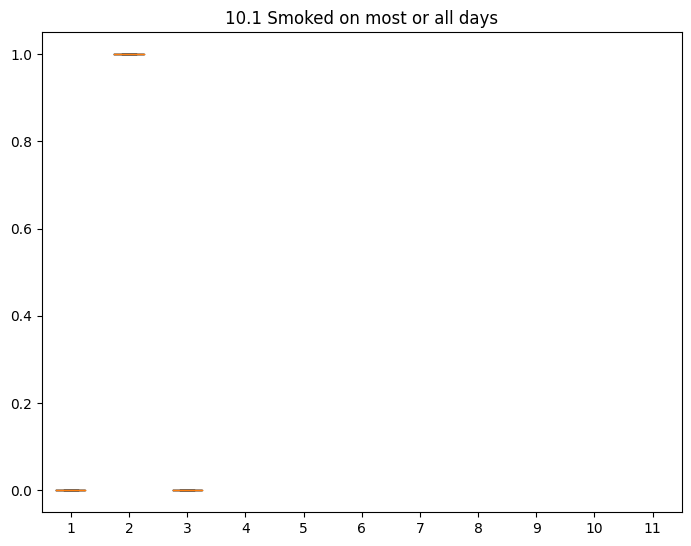

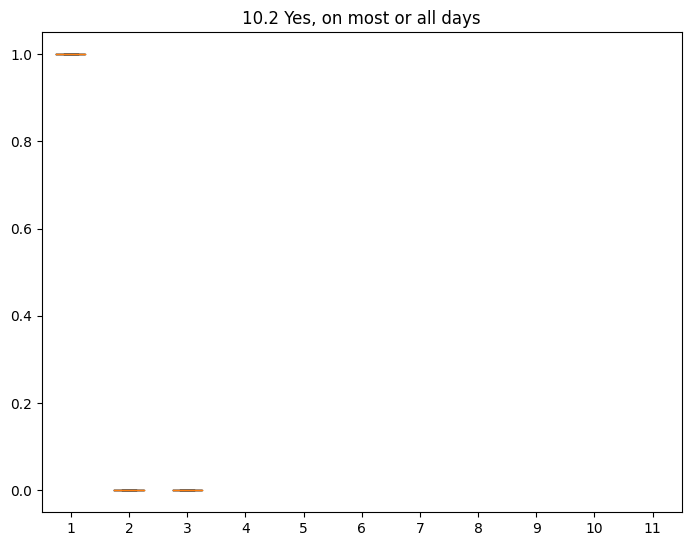

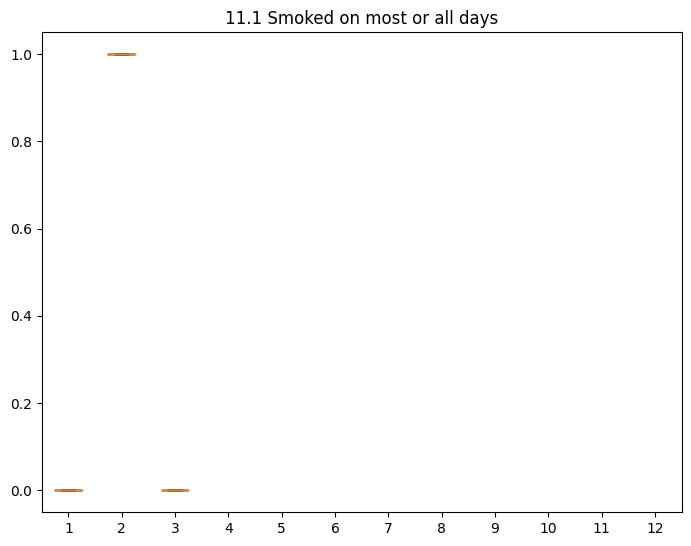

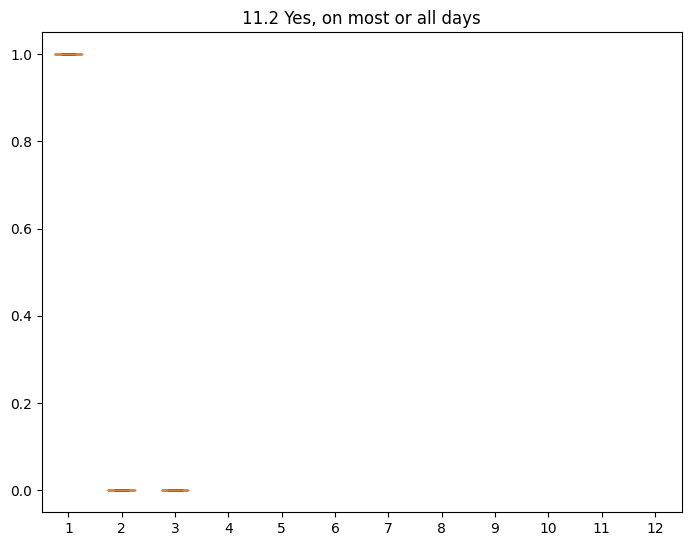

In [174]:
qa = QA(df=copd[datacolumns_selected].loc[(copd["Date J44 first reported (other chronic obstructive pulmonary disease)_binary"] == 1)].dropna(),
        datacolumns=datacolumns_selected, min_clus=2, max_clus=12, wd="C:/Users/keimp/")
qa.cluster_construction_iterative()

x=1
for i in qa.clustered_dfs:
    y=1
    for c in datacolumns_selected:
        d = []
        for j in i:
            d.append(j[c])
        boxplot_timseries(d, str(x)+"."+str(y)+" "+c , abline=False)
        y+=1

    x+=1

In [175]:
x=1
for i in qa.clustered_dfs:
    y=1
    for j in i:
        print(x, ".", y, " ", j.shape)
        y+=1
    x+=1

1 . 1   (16362, 3)
1 . 2   (11414, 3)
2 . 1   (8046, 4)
2 . 2   (11414, 4)
2 . 3   (8316, 4)
3 . 1   (8046, 5)
3 . 2   (11414, 5)
3 . 3   (8316, 5)
3 . 4   (0, 5)
4 . 1   (8046, 6)
4 . 2   (11414, 6)
4 . 3   (8316, 6)
4 . 4   (0, 6)
4 . 5   (0, 6)
5 . 1   (8046, 7)
5 . 2   (11414, 7)
5 . 3   (8316, 7)
5 . 4   (0, 7)
5 . 5   (0, 7)
5 . 6   (0, 7)
6 . 1   (8046, 8)
6 . 2   (11414, 8)
6 . 3   (8316, 8)
6 . 4   (0, 8)
6 . 5   (0, 8)
6 . 6   (0, 8)
6 . 7   (0, 8)
7 . 1   (8046, 9)
7 . 2   (11414, 9)
7 . 3   (8316, 9)
7 . 4   (0, 9)
7 . 5   (0, 9)
7 . 6   (0, 9)
7 . 7   (0, 9)
7 . 8   (0, 9)
8 . 1   (8046, 10)
8 . 2   (11414, 10)
8 . 3   (8316, 10)
8 . 4   (0, 10)
8 . 5   (0, 10)
8 . 6   (0, 10)
8 . 7   (0, 10)
8 . 8   (0, 10)
8 . 9   (0, 10)
9 . 1   (8046, 11)
9 . 2   (11414, 11)
9 . 3   (8316, 11)
9 . 4   (0, 11)
9 . 5   (0, 11)
9 . 6   (0, 11)
9 . 7   (0, 11)
9 . 8   (0, 11)
9 . 9   (0, 11)
9 . 10   (0, 11)
10 . 1   (8046, 12)
10 . 2   (11414, 12)
10 . 3   (8316, 12)
10 . 4   (0, 12)
10 .

Leaving bronchictasis as might be less impacted by lifestyle factors

Index(['Smoked on most or all days', 'Yes, on most or all days', 'cluster_0',
       'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4'],
      dtype='object')

In [107]:
copd["age_copd"][:5]

0     NaN
1    53.0
2     NaN
3     NaN
4     NaN
Name: age_copd, dtype: float64

In [55]:
copd['Exposure to tobacco smoke at home | Instance 0'].value_counts()

0                       425318
Do not know               9928
1                         9729
2                         3342
Prefer not to answer      1594
                         ...  
161                          1
58                           1
23                           1
53                           1
67                           1
Name: Exposure to tobacco smoke at home | Instance 0, Length: 105, dtype: int64

In [89]:
copd.columns.tolist()

['Participant ID',
 'Date J40 first reported (bronchitis, not specified as acute or chronic)',
 'Date J41 first reported (simple and mucopurulent chronic bronchitis)',
 'Date J42 first reported (unspecified chronic bronchitis)',
 'Date J43 first reported (emphysema)',
 'Date J44 first reported (other chronic obstructive pulmonary disease)',
 'Date J47 first reported (bronchiectasis)',
 'Date J40 first reported (bronchitis, not specified as acute or chronic)_binary',
 'Date J41 first reported (simple and mucopurulent chronic bronchitis)_binary',
 'Date J42 first reported (unspecified chronic bronchitis)_binary',
 'Date J43 first reported (emphysema)_binary',
 'Date J44 first reported (other chronic obstructive pulmonary disease)_binary',
 'Date J47 first reported (bronchiectasis)_binary',
 'all_copd',
 'Vascular/heart problems diagnosed by doctor | Instance 0_x',
 'Vascular/heart problems diagnosed by doctor | Instance 1_x',
 'Vascular/heart problems diagnosed by doctor | Instance 2_x',